# Identifying Master Regulator Dependencies in Pediatric Osteosarcoma
### *Jovana Pavisic and Jonah Einson*

In [204]:
# Packges Used in this thing
suppressPackageStartupMessages(library(viper))       # Bioconductor: Viper MR analysis pipeline
suppressPackageStartupMessages(library(factoextra))  # install_github("kassambara/factoextra"), another clustering and visualization tool
suppressPackageStartupMessages(library(NbClust))     # CRAN, Determining the best number of clusters
suppressPackageStartupMessages(library(cluster))     # CRAN, Perform clustering analysis
suppressPackageStartupMessages(library(RColorBrewer))# CRAN, for making pretty plots
suppressPackageStartupMessages(library(gplots))      # CRAN, for making heatmaps
suppressPackageStartupMessages(library(magrittr))    # CRAN, Pronounce with a sophisticated french accent
suppressPackageStartupMessages(library(survival))    # CRAN, Perform survival Analysis
suppressPackageStartupMessages(library(survminer))   # CRAN, gets information out of survival objects
suppressWarnings(suppressPackageStartupMessages(library(tidyverse))) # Other tidy tools
library(readxl)

## Running Viper on TPM Counts
This might take a while...

In [297]:
## Generate a Gene Expression Dataset ##

# Created a gene expression matrix with genes as rows (Ensemble IDs), patient samples as columns, and TPM (transcripts per million) as values from data available on the TARGET Data Matrix.
# Original data has 45,476 rows (Ensemble ID genes) and 84 columns (patient samples).
OSDataTPM <- as.matrix(read.delim("SourceCode_Files/TOS_TPM.txt", header = TRUE, sep = "\t", row.names = 1, stringsAsFactors = FALSE))

# Convert Ensemble gene IDs to Entrez gene IDs as VIPER requires Entrez IDs. Use ens2entrez.rda obtained form n1platform package.
# As one Entrez ID maps to multiple Ensemble IDs, must sum these counts.
# The function EnsEntrez both coverts all ensemble IDs to entrez IDs when available (removes genes that don't have entrez ID) and sums the counts of all of the same entrez IDs.
load(file = "SourceCode_Files/ens2entrez.rda")
EnsEntrez <- function(dset){
  rn <- ens2entrez[rownames(dset)]
  pos_rn <- !is.na(rn)
  dset <- dset[pos_rn,]
  rn <- rn[pos_rn]
  dset_Entrez <- matrix(NA,nr=length(unique(rn)),nc=ncol(dset))
  rownames(dset_Entrez) <- as.character(unique(rn)); colnames(dset_Entrez) <- colnames(dset)
  z=0
  for(m in unique(rn)){
    vec <- names(rn)[rn==m]
    if(length(vec) > 1) {output <- rowSums(dset[vec,])}else{
      output <- dset[vec,]
    }
    dset_Entrez[as.character(m),] <- output
    z=z+1; 
  }
  return(dset_Entrez)
}

# Use above function to generate matrix with Entrez IDs and TPMs for each gene across the TARGET samples.
# We now have 20,895 rows or genes with Entrez IDs and still 84 columns (patient samples).
OSDataTPM_Entrez <- EnsEntrez(OSDataTPM) 

# Log transform TPM counts in order to make them log normally distributed across genes for further analyses.
OSDataLogTPM <- apply(OSDataTPM_Entrez, 2, function(i){log10(i+0.25)})
# Adjust TARGET sample names to match those of clinical files for easier comparison in future.
colnames(OSDataLogTPM) <- colnames(OSDataLogTPM) %>% gsub(".01A.01R", "", .) %>% gsub("\\.", "-", .)

## Run VIPER to Create a Protein Activity Matrix ##

# Run Viper with gene expression matrix using logTPMs (it automatically calculates sample-specific gene expression signatures using a scaling method and the average across our samples as the baseline expression)
TOS_viper_LogTPM_Scale <- viper(eset = OSDataLogTPM, regulon = getInteractome(regulonSets('all')), method = "scale", cores=2)
# Convert gene names from Entrez IDs for actual gene names fur further analyses.
row.names(TOS_viper_LogTPM_Scale) <- entrez2gene(rownames(TOS_viper_LogTPM_Scale))


Computing the association scores


ERROR: Error in getInteractome(regulonSets("all")): could not find function "getInteractome"


At this point, we should have a table of patients and MR signatures. From previous steps, load this into our R environment.

## Read in Viper Data

Do this if you don't want to wait for your computer to find MR signatures by itself

In [173]:
TOS_viper_LogTPM_Scale <- read.csv("SourceCode_Files/viper_dset.csv")

In [174]:
#Select most differentially active MRs by variance across rows. These 30 MRs serve as our main features for clustering.
TopMRScale <- TOS_viper_LogTPM_Scale[order(rowVars(TOS_viper_LogTPM_Scale[,-1]), decreasing = T)[1:30],]
rownames(TopMRScale) <- TopMRScale[,1]
TopMRScale <- TopMRScale[,-1]

## Data Pre-Processing

First, we summarize the metastasis and relapse statuses of the patients in our cohort. 

### Read in and clean up the clinical data file

In [170]:
OSClinical <- read.csv("SourceCode_Files//TARGET_OS_Discovery_ClinicalData.csv") 
OSClinical[,paste0("X__", 1:5)] <- NULL # Get rid of extra columns
OSClinical[1:10,] 

TARGET.USI,Gender,Race,Ethnicity,Age.at.Diagnosis.in.Days,First.Event,Time.to.First.Event.in.Days,Vital.Status,Overall.Survival.Time.in.Days,Year.of.Diagnosis,...,Site.of.initial.relapse,Time.to.first.relapse.in.days,Time.to.first.enrollment.on.relapse.protocol.in.days,Time.to.first.SMN.in.days,Time.to.death.in.days,Histologic.response,Percent.necrosis.at.Definitive.Surgery,Relapse.Type,Therapy,Comment
TARGET-40-PAMRHD,Female,Unknown,Not Hispanic or Latino,3942,Relapse,39,Dead,74,2003,...,Lung,39,NA,NA,74,,,,,NA
TARGET-40-PAMLKS,Female,White,Not Hispanic or Latino,4509,Relapse,71,Dead,180,2003,...,,71,NA,NA,180,,,,,NA
TARGET-40-PAMYYJ,Male,White,Not Hispanic or Latino,6477,Relapse,128,Dead,271,2004,...,Lung,128,NA,NA,271,,67,,,NA
TARGET-40-0A4HY5,Male,,,7264,Relapse,218,Dead,290,2004,...,Regional Lymph nodes,218,NA,NA,290,Stage 1/2,50,,Adria/Plat/MTX,NA
TARGET-40-PANPUM,Male,White,Not Hispanic or Latino,5996,Relapse,46,Dead,295,2005,...,,46,NA,NA,295,,,,,NA
TARGET-40-PAUVUL,Female,Black or African American,Not Hispanic or Latino,2027,Relapse,237,Dead,347,2012,...,,237,NA,NA,347,,,,,NA
TARGET-40-PATMXR,Female,Hispanic or Latino,Hispanic or Latino,7631,Relapse,68,Dead,386,2010,...,,68,NA,NA,386,,,,,NA
TARGET-40-PAPKWD,Male,White,Not Hispanic or Latino,3478,Relapse,192,Dead,422,2006,...,"Non-bone, non-lung",192,NA,NA,422,0-90,,,,NA
TARGET-40-PATUXZ,Female,Hispanic or Latino,Hispanic or Latino,6345,Death,510,Dead,510,2010,...,,NA,NA,NA,510,,,,,NA
TARGET-40-0A4I0Q,Female,,,7269,Death,519,Dead,519,2005,...,,NA,NA,NA,519,Stage 1/2,< 50,,MTX/Adria/Ifos/ñPlat,NA


In [171]:
## Deneral descriptive statistics of the TARGET clinical data ##

# Create vector of primary events for each patient: No event, Relapse, Death
events <- OSClinical$`First.Event`
events <- events %>% gsub("Censored", "No event", .) %>% gsub("SMN", "No event", .) %>% as.factor()
names(events) <- OSClinical$`TARGET.USI`

events[1:10]

TARGET-40-PAMRHD TARGET-40-PAMLKS TARGET-40-PAMYYJ TARGET-40-0A4HY5 
         Relapse          Relapse          Relapse          Relapse 
TARGET-40-PANPUM TARGET-40-PAUVUL TARGET-40-PATMXR TARGET-40-PAPKWD 
         Relapse          Relapse          Relapse          Relapse 
TARGET-40-PATUXZ TARGET-40-0A4I0Q 
           Death            Death 
Levels:  Death No event Relapse

In [172]:
# Create vector of primary metastatic vs non-metastatic disease for each patient: Metastatic, Non-metastatic
DxDisease <- OSClinical$`Disease.at.diagnosis`
DxDisease <- DxDisease %>% gsub(" \\([Cc]onfirmed\\)", "", .) %>% as.factor()
names(DxDisease) <- OSClinical$`TARGET.USI`

DxDisease[1:10]

TARGET-40-PAMRHD TARGET-40-PAMLKS TARGET-40-PAMYYJ TARGET-40-0A4HY5 
      Metastatic       Metastatic       Metastatic       Metastatic 
TARGET-40-PANPUM TARGET-40-PAUVUL TARGET-40-PATMXR TARGET-40-PAPKWD 
      Metastatic       Metastatic       Metastatic   Non-metastatic 
TARGET-40-PATUXZ TARGET-40-0A4I0Q 
      Metastatic       Metastatic 
Levels: Metastatic Non-metastatic

In [175]:
TopMRScale

,TARGET.40.0A4HLD.01A.01R,TARGET.40.PAPIJR.01A.01R,TARGET.40.PAMHLF.01A.01R,TARGET.40.PATAWV.01A.01R,TARGET.40.0A4I42.01A.01R,TARGET.40.PAMJXS.01A.01R,TARGET.40.PALECC.01A.01R,TARGET.40.0A4HMC.01A.01R,TARGET.40.0A4I6O.01A.01R,TARGET.40.PANMIG.01A.01R,...,TARGET.40.PASRNE.01A.01R,TARGET.40.PAMHYN.01A.01R,TARGET.40.0A4I4O.01A.01R,TARGET.40.PAPKWD.01A.01R,TARGET.40.PASEBY.01A.01R,TARGET.40.0A4I0Q.01A.01R,TARGET.40.PAVDTY.01A.01R,TARGET.40.PARBGW.01A.01R,TARGET.40.PAUUML.01A.01R,TARGET.40.PAMLKS.01A.01R
CD86,-3.08138393,15.73665638,-3.33688495,-4.4862216,-1.9816824,-2.9142214,6.2719530,10.8646842,-4.4701543,-1.2326447,...,8.825390,5.7741167,0.71663484,-10.1434796,9.537527,-0.3699840,4.4012590,5.909368,-15.897990,-7.834264
SPI1,-3.92428032,15.54881579,-3.39151535,-5.9453881,-2.4228621,-1.3281939,7.7852592,12.0288773,-5.5816922,-1.7412502,...,6.532600,3.9318078,3.66456232,-8.8381956,7.493700,-2.2026337,4.6092919,4.893894,-14.422925,-4.607822
IL16,1.37351172,11.81674366,1.12433884,-3.3617053,-3.5346804,-4.9613184,0.6548722,7.4730821,-3.2526908,1.0351641,...,4.290124,5.1869593,-2.15804887,-11.5904525,6.894399,2.1373929,3.5408925,3.260308,-11.869669,-8.234461
MNDA,-2.16692966,11.35173967,-1.27106567,-3.1214955,-2.1892064,-3.0461668,4.0300428,6.8618208,-3.2496915,0.7175807,...,7.211234,4.7366935,-1.40659699,-8.8010430,7.910091,1.5709309,2.6735243,4.622825,-12.092999,-7.646276
NDUFA13,-9.38799725,-0.33861146,-0.14960543,-4.7048800,-4.1214133,6.9599683,9.9369418,2.2428969,-1.6825546,-9.3392651,...,-5.629975,2.1956466,-0.22145886,2.6184023,-4.366040,-3.3924148,1.5320178,5.991350,-6.650856,15.334802
MRPL12,-7.81307638,-0.80516108,-3.13985524,-5.1720852,-4.8188808,6.0747865,8.0514863,0.2172739,-2.8038620,-10.2777629,...,-7.358026,0.2530531,0.78585240,6.5478401,-3.316215,-3.8411412,2.1818046,5.100424,-2.356996,18.847380
TNFRSF4,-2.93533184,12.52219001,-1.11793548,-6.6099619,-3.5424752,-1.1713951,5.1151117,10.2852961,-6.0233477,-2.4658486,...,1.979100,1.5193729,1.61880047,-8.5777339,4.664520,-0.8590298,4.8857829,4.724887,-10.336977,-3.731795
CIITA,0.06812567,11.14481458,1.09359032,-2.9832906,-2.7297230,-3.3255808,2.4321963,7.8481445,-3.3757036,0.2821081,...,4.168214,4.1753451,-1.76627189,-8.2556909,6.942724,1.9260464,3.5577755,3.803158,-9.995051,-6.401932
RPS14,-10.03987637,-1.20780073,-5.48190945,-1.6605065,-4.5138261,2.6351861,5.7929700,1.5973927,-6.9999767,-6.0504747,...,-8.081242,3.0023383,-2.77702587,9.2495998,-6.766213,6.6762935,0.7008100,5.436483,-4.179925,16.131839
NME2,-9.47184064,-2.09953811,-4.88935414,-1.7720916,-4.8275670,3.6086311,7.2558940,-1.2981596,-4.3277171,-8.4197635,...,-6.551137,2.4510696,-2.87974921,8.5942287,-4.647961,2.9447007,1.0256259,5.983428,-4.273471,17.563017


# Question 1: Identifying groups of pediatric OS patients who share common MR signatures

## Hard Clustering

Importance of components:
                         PC1    PC2     PC3     PC4     PC5    PC6     PC7
Standard deviation     3.980 3.2392 1.15585 0.98551 0.62330 0.5423 0.47826
Proportion of Variance 0.528 0.3498 0.04453 0.03237 0.01295 0.0098 0.00762
Cumulative Proportion  0.528 0.8778 0.92230 0.95468 0.96763 0.9774 0.98505
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.42341 0.27864 0.19156 0.16542 0.14611 0.14187 0.12607
Proportion of Variance 0.00598 0.00259 0.00122 0.00091 0.00071 0.00067 0.00053
Cumulative Proportion  0.99103 0.99362 0.99484 0.99575 0.99647 0.99714 0.99767
                          PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.11507 0.10212 0.09483 0.08164 0.07938 0.06998 0.05953
Proportion of Variance 0.00044 0.00035 0.00030 0.00022 0.00021 0.00016 0.00012
Cumulative Proportion  0.99811 0.99846 0.99876 0.99898 0.99919 0.99935 0.99947
                          PC22    PC23    

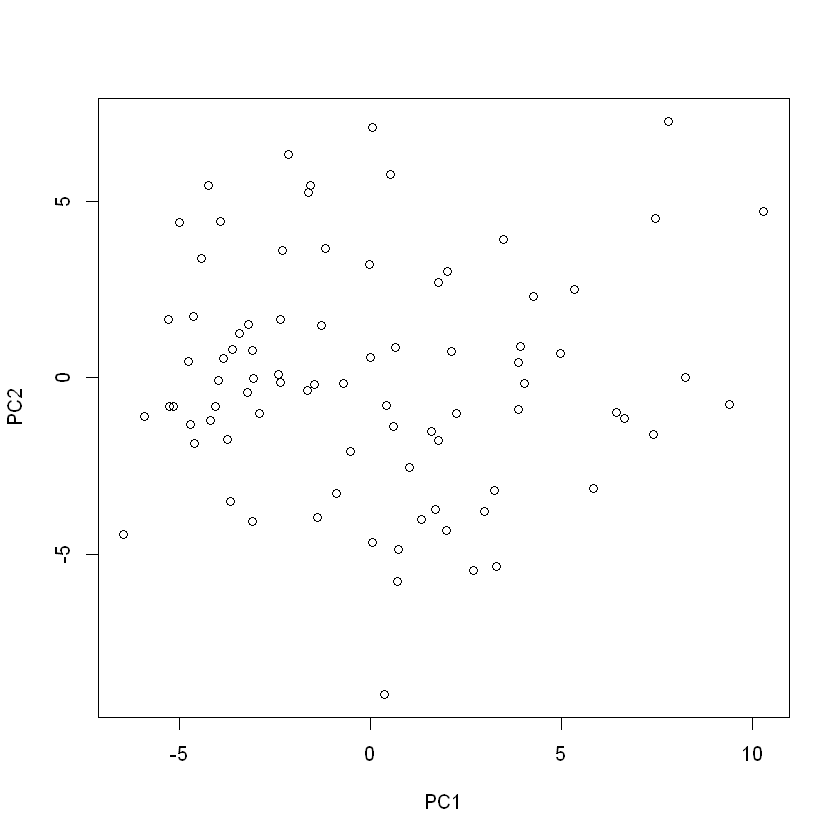

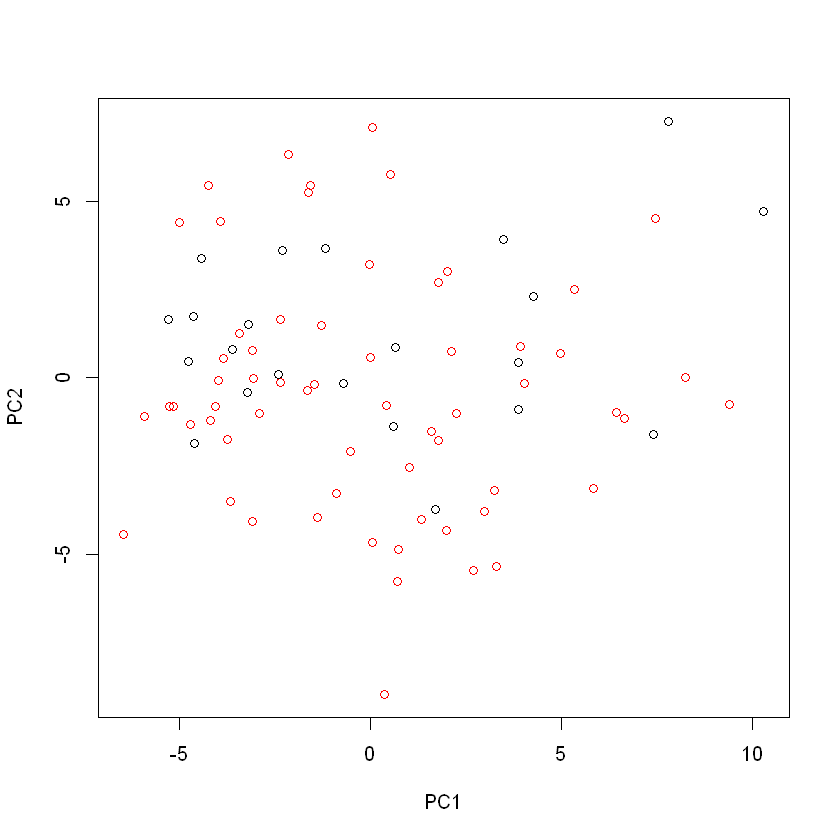

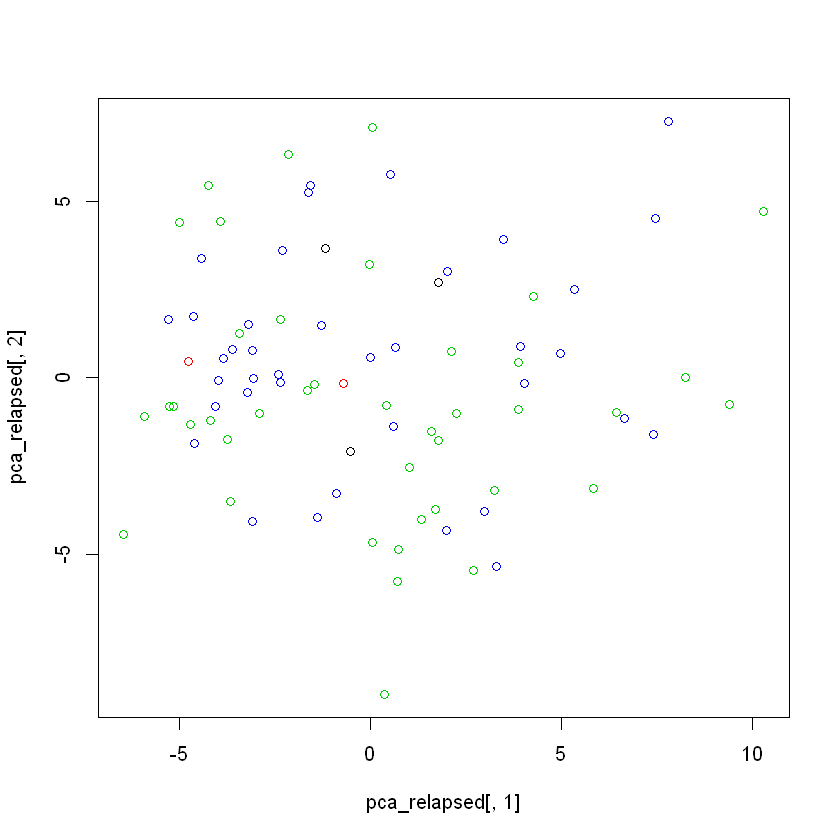

In [176]:
# PCA of the top 30 genes colored by relapse and by metastatic state. Don't see good discrimination by PCA even though the top two components acount for 87.8% of the variation.
TopMRScale_transposed <- t(TopMRScale)
pca <- prcomp(TopMRScale_transposed, scale = TRUE)
summary(pca) # see that PC1 explains 52.8% of the variance and PC2 explains 34.9% of the variance
pcar <- pca$x
rownames(pcar) <- rownames(pcar) %>% gsub(".01A.01R", "", .) %>% gsub("\\.", "-", .)
pca_relapsed <- cbind(pcar, events[rownames(pcar)])
pca_metastatic <- cbind(pcar, DxDisease[rownames(pcar)])
plot(pcar[,c(1,2)]) 
plot(pca_metastatic[,c(1,2)], col = pca_metastatic[,ncol(pca_metastatic)])
plot(pca_relapsed[,1], pca_relapsed[,2], col = pca_relapsed[,ncol(pca_relapsed)])

Evaluate cluster tendency or feasibility of clustering analyses
Using statistical method - Hopkins statistic - and visual assessment of cluster tendency (VAT) algorithm. For Hopkins statistic, H > 0.75 indicates a clustering tendency at the 90% confidence level

[[1]]
[1] 0.7549057

[[2]]


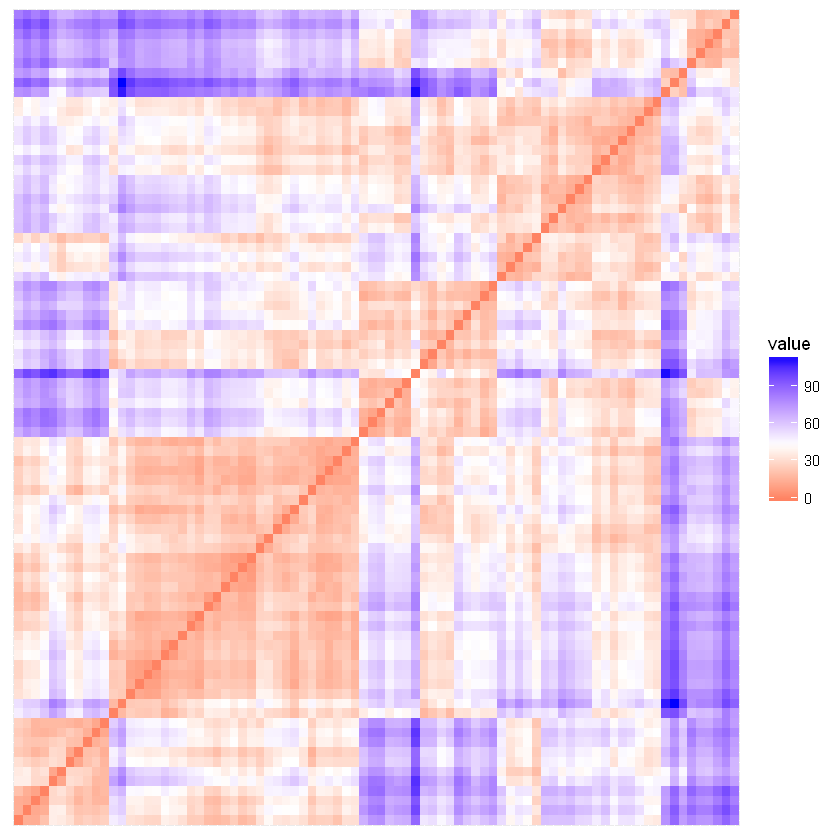

In [177]:
ClusterTendency <- function(vipnes){
  vipnes2 <- t(vipnes)
  HClustTend <- get_clust_tendency(data = vipnes2, n = nrow(vipnes2) - 1, graph = TRUE)
  return(list(HClustTend$hopkins_stat, HClustTend$plot))
}

ClusterTendency(TopMRScale) # 0.755 for top 30 suggesting some clustering tendency supporting ongoing clustering efforts.

Attempted different clustering methods using average silhouette width as measure of internal cluster quality 

#### K-means clustering: attempted different k (2-6)

  cluster size ave.sil.width
1       1   22          0.35
2       2   20          0.28
3       3   42          0.35


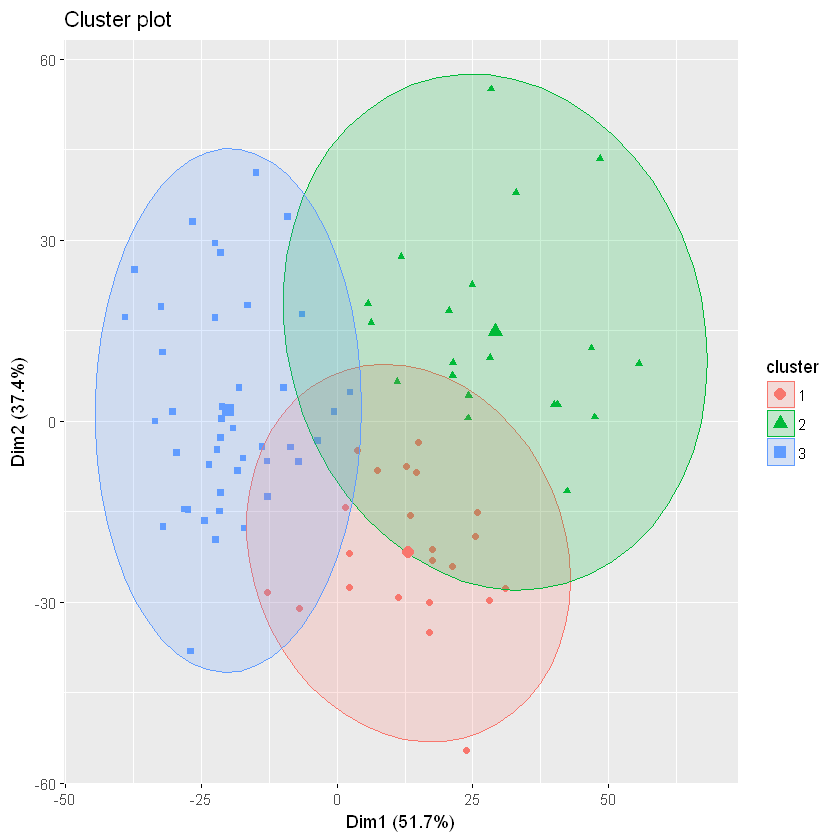

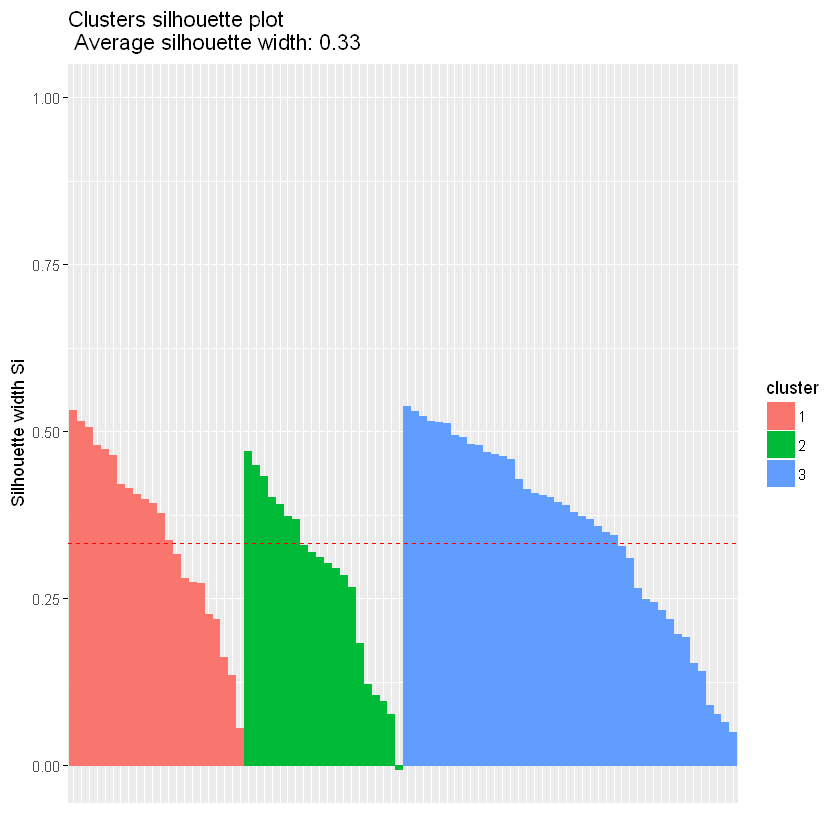

In [178]:
set.seed(123)
km.res <- kmeans(t(TopMRScale), 3, nstart = 25)
kmClusterAssignment <- km.res$cluster
fviz_cluster(km.res, data = t(TopMRScale), geom = "point", stand = FALSE, ellipse.type = "norm")
# Evaluating silhouette width for K-means clustering, typically around 0.3-0.35
kmSampleDistance <- dist(t(TopMRScale), method = "euclidean")
kmsil <- silhouette(kmClusterAssignment, kmSampleDistance)
fviz_silhouette(kmsil) 

#### PAM (Partitioning Around Mediods) Clustering

  cluster size ave.sil.width
1       1   34          0.31
2       2   18          0.35
3       3   21          0.24
4       4   11          0.41


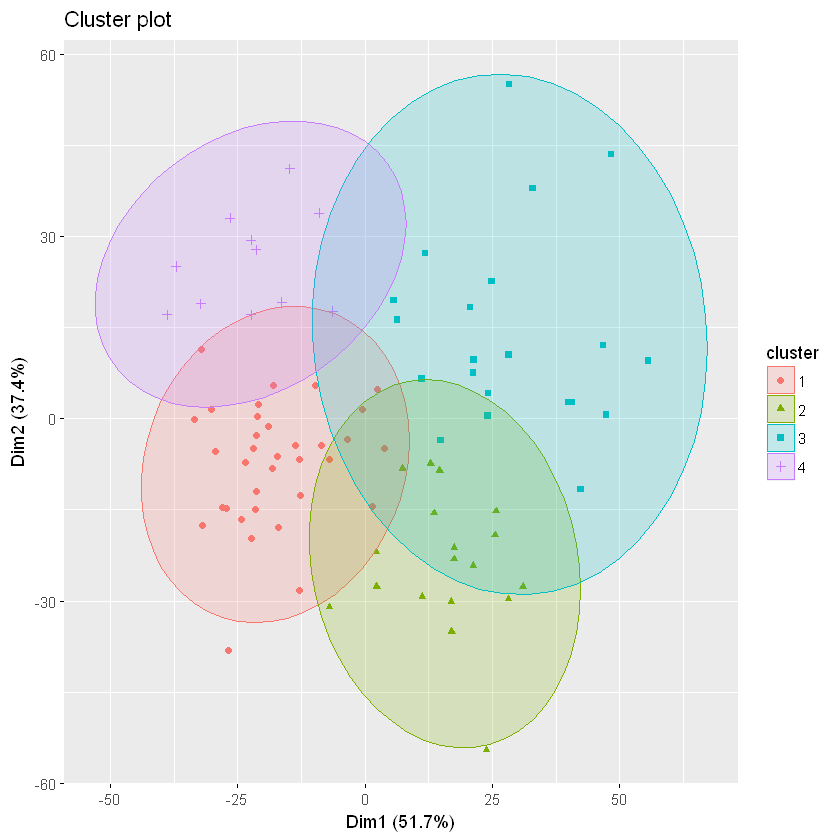

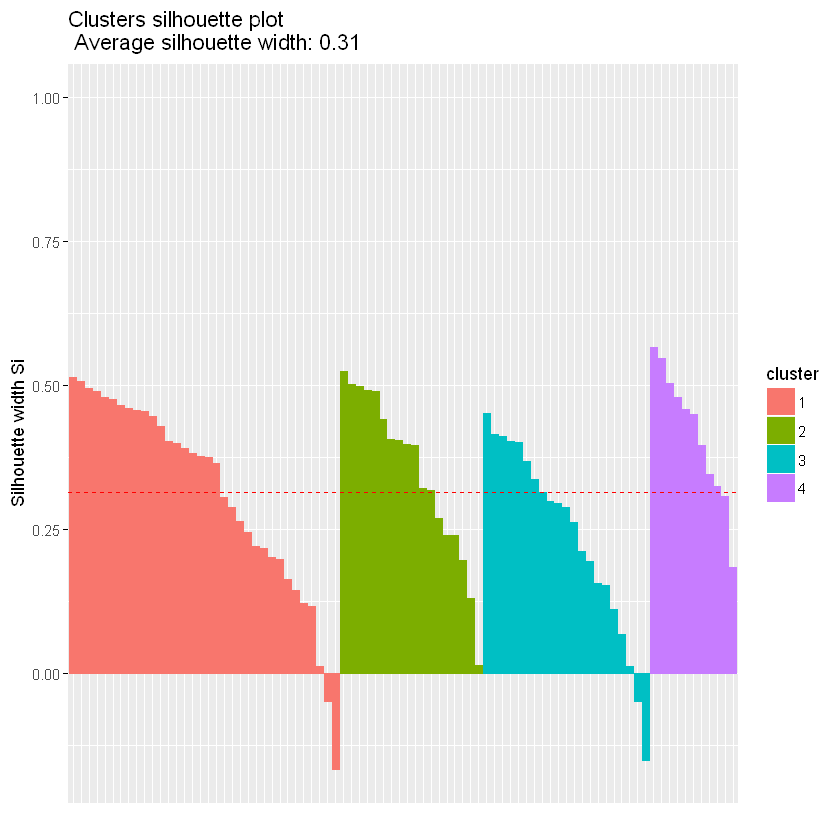

In [179]:
pam.res <- pam(t(TopMRScale), 4)
pamClusterAssignment <- pam.res$clustering
fviz_cluster(pam.res, stand = FALSE, geom = "point", ellipse.type = "norm")
# Evaluating silhouette width for PAM clustering
pamsil <- silhouette(pamClusterAssignment, kmSampleDistance)
fviz_silhouette(pamsil)

#### Determining optimal number of clusters using factoextra pacakge 
Using average silhouette method and hierarchical clustering

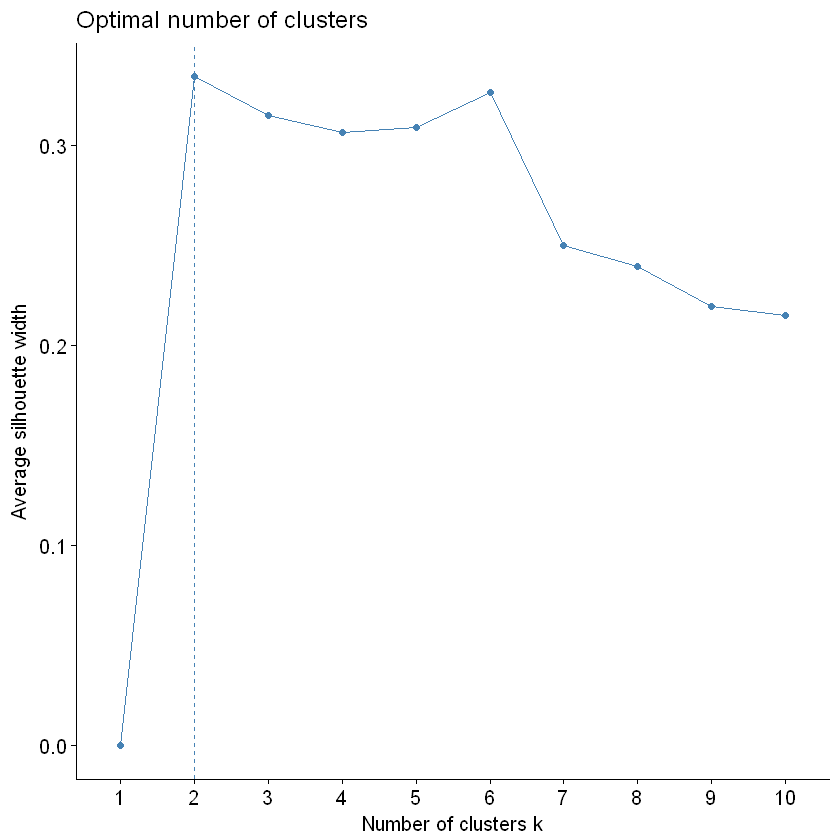

In [180]:
fviz_nbclust(t(TopMRScale), hcut, method = "silhouette") # says that average silhouette width is optimized with 2 clusters but 2-6 clusters have similar average silhouette width of ~0.3-0.35.


NbClust returns 30 indices for determining the relevant number of clusters and proposes to users the best clustering scheme from the different results obtained by varying all combinations of number of clusters, distances measures, and clustering methods.m

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 


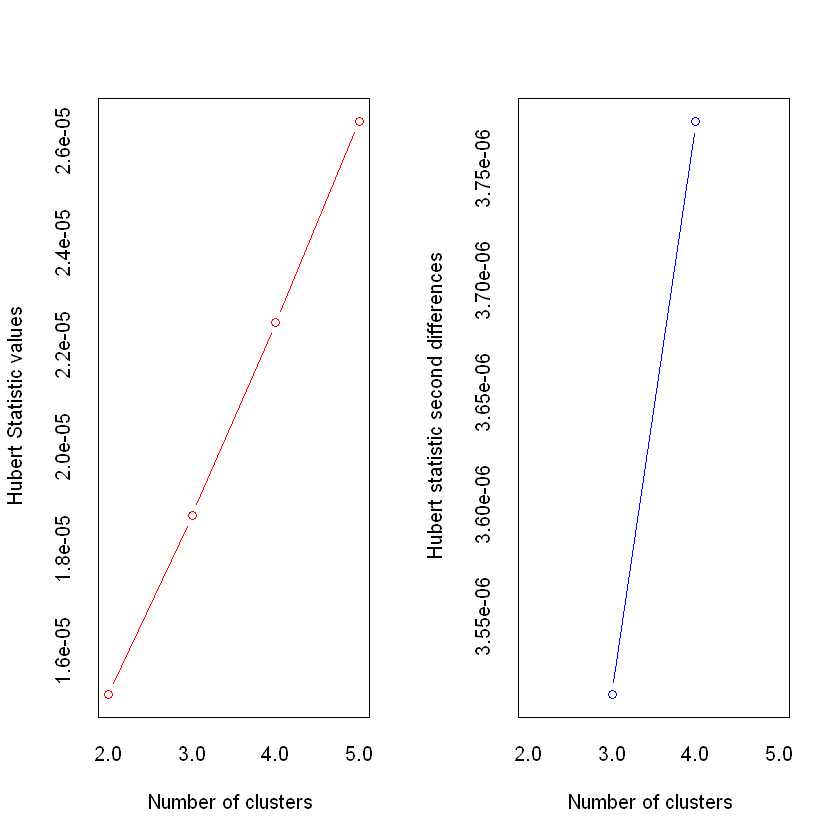

*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 2 proposed 2 as the best number of clusters 
* 5 proposed 3 as the best number of clusters 
* 7 proposed 4 as the best number of clusters 
* 6 proposed 5 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  4 
 
 
******************************************************************* 
Among all indices: 
* 2 proposed  0 as the best number of clusters
* 1 proposed  1 as the best number of clusters
* 2 proposed  2 as the best number

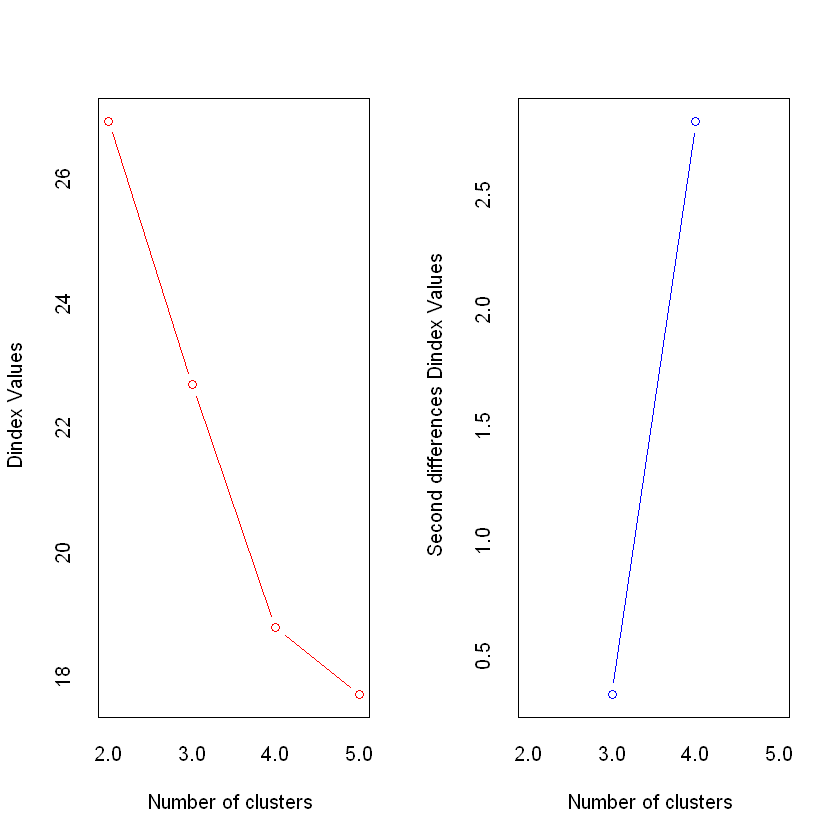

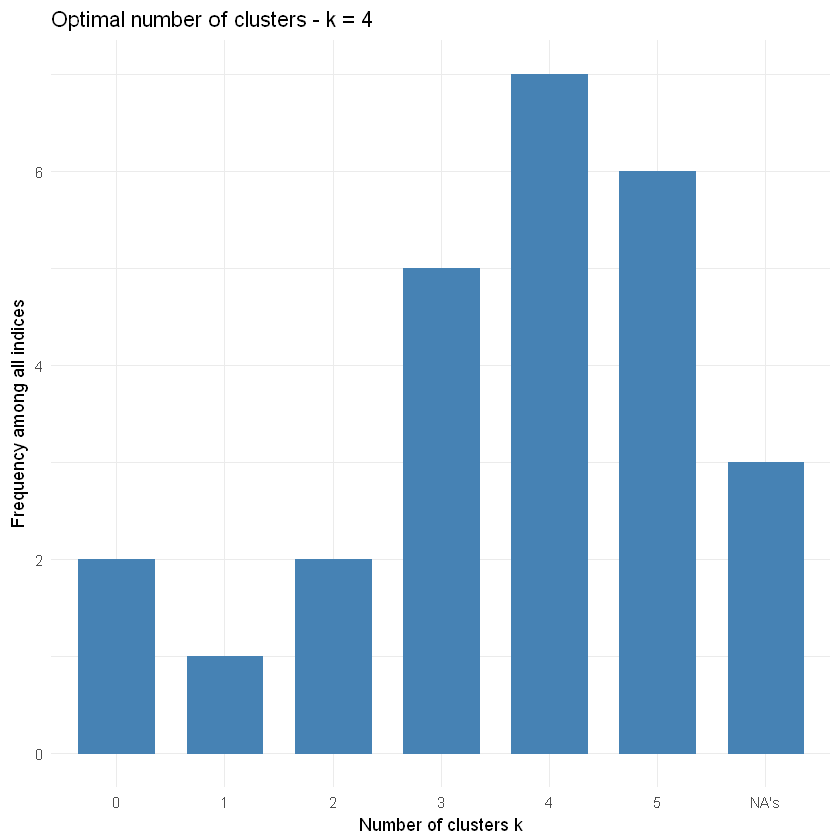

In [181]:
set.seed(123)
res.nb <- NbClust(data = t(TopMRScale), diss = NULL, distance = "euclidean", min.nc = 2, max.nc = 5, method = "complete", index = "all")
fviz_nbclust(res.nb) + theme_minimal()

## 1.2 Hierarchical Clustering

In [182]:
SampleClusters <- as.hclust(hm_ED$colDendrogram)
ClusterAssignment <- cutree(SampleClusters, k = 4)
sidecols2 <- brewer.pal(4, "Set1")[ClusterAssignment]

Label the columns by their cluster assignment

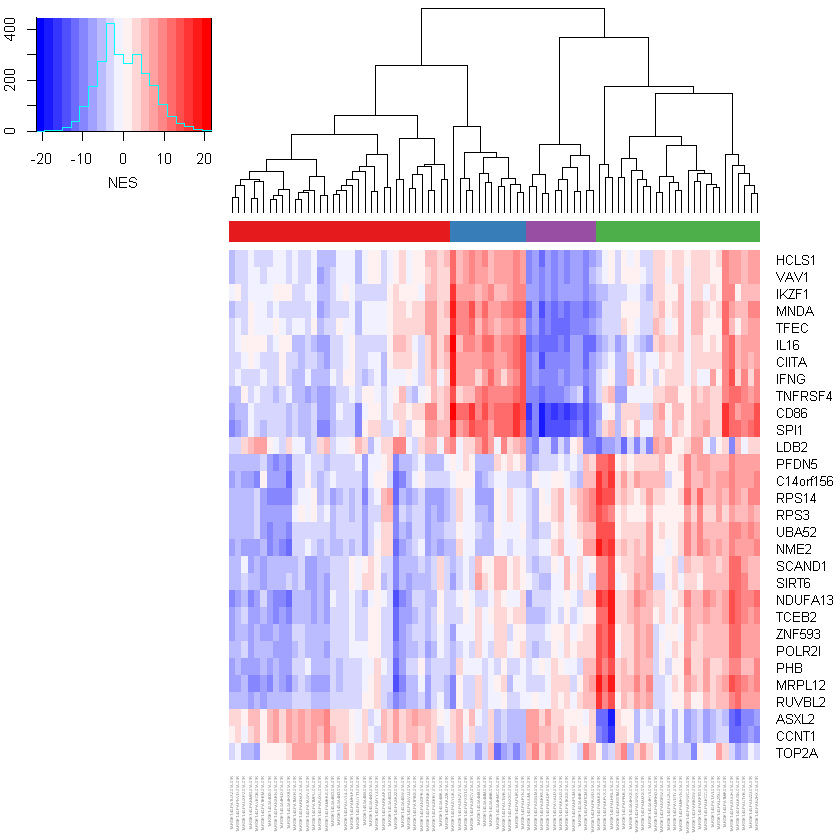

In [183]:
hm_ED <- heatmap.2(x = TopMRScale %>% as.matrix, dendrogram = "column",
                   col = colorRampPalette(c('blue','white','red'))(n=20),
                   ColSideColors = sidecols2, 
                   trace = "none", cexCol = 0.3, cexRow = 1,
                   key.title = NA, key.xlab = "NES", key.ylab = NA)

Calculating silhouett width for hierarchical clustering with 4 final clusters

  cluster size ave.sil.width
1       1   35          0.30
2       2   12          0.45
3       3   26          0.16
4       4   11          0.45


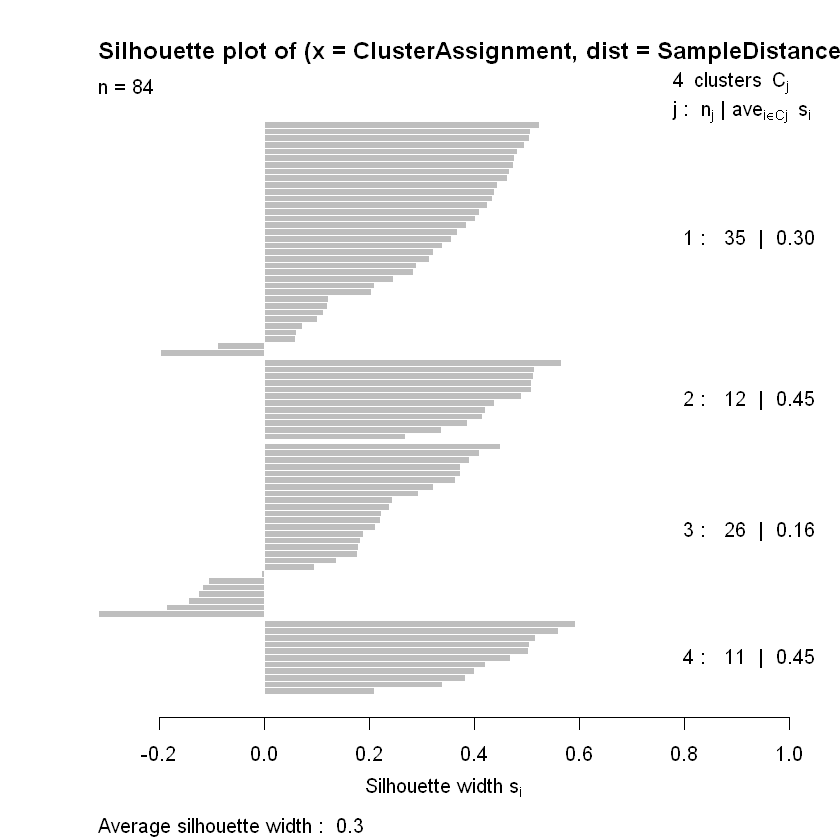

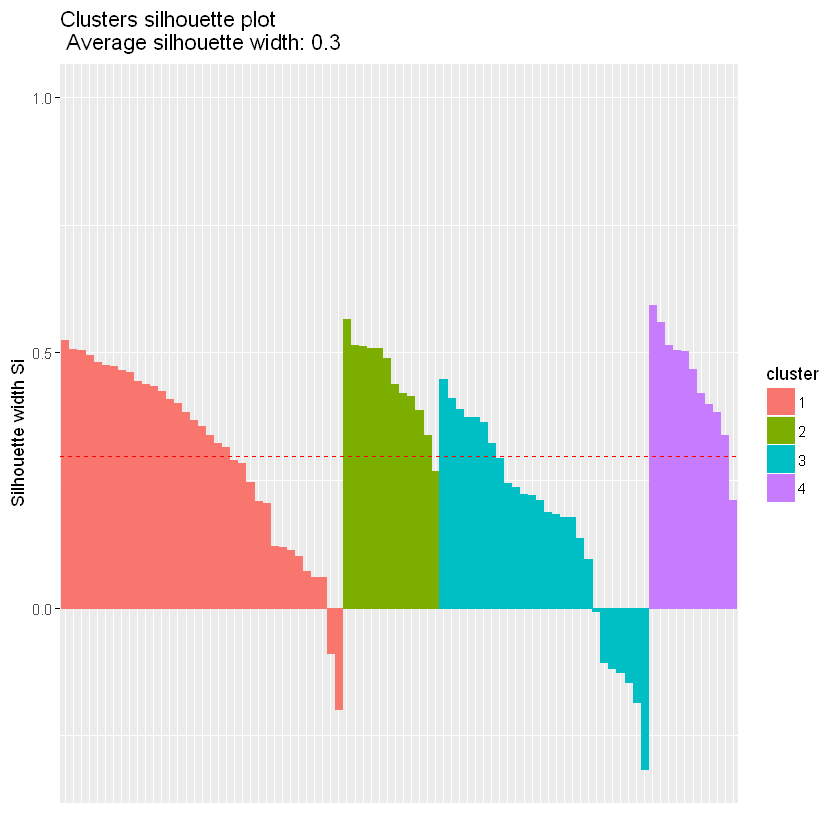

In [184]:
SampleDistance <- dist(TopMRScale_transposed, method = "euclidean")
sil <- silhouette(ClusterAssignment, SampleDistance)
plot(sil) # Moderate average silhouette scores per cluster. Per pairing, max score is ~0.55. Cluster averages are cluster 1 0.3, cluster 2 0.45, cluster 3 0.16, cluster 4 0.45
fviz_silhouette(sil) # 4 clusters seems to optimize average silhouette width and visual assessment for our data

### Other hierarchical methods attempted that lead to less robust clusters ##

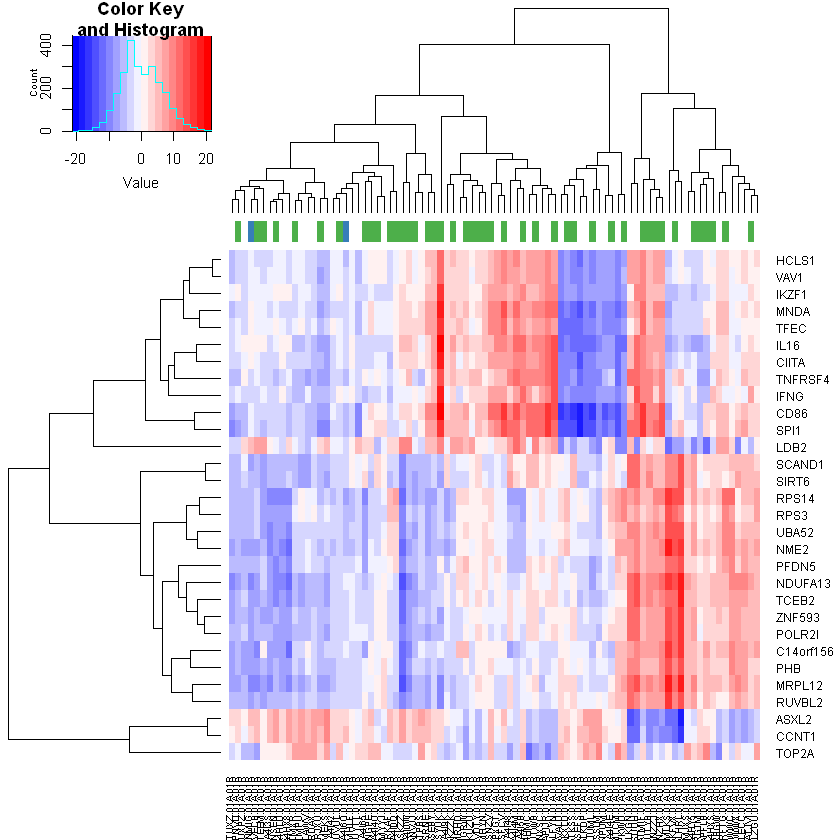

In [185]:
hm_man <- heatmap.2(x = as.matrix(TopMRScale), 
          distfun = function(x) dist(x, method = "manhattan"),
          col = colorRampPalette(c('blue','white','red'))(n=20),
          ColSideColors = sidecols, trace = "none")

In [186]:
SampleClusters_man <- as.hclust(hm_man$colDendrogram)
ClusterAssignment_man <- cutree(SampleClusters_man, k = 4)
sidecols_manhattan <- brewer.pal(4, "Set1")[ClusterAssignment_man]

  cluster size ave.sil.width
1       1   52          0.18
2       2   15          0.13
3       3   11          0.52
4       4    6          0.49


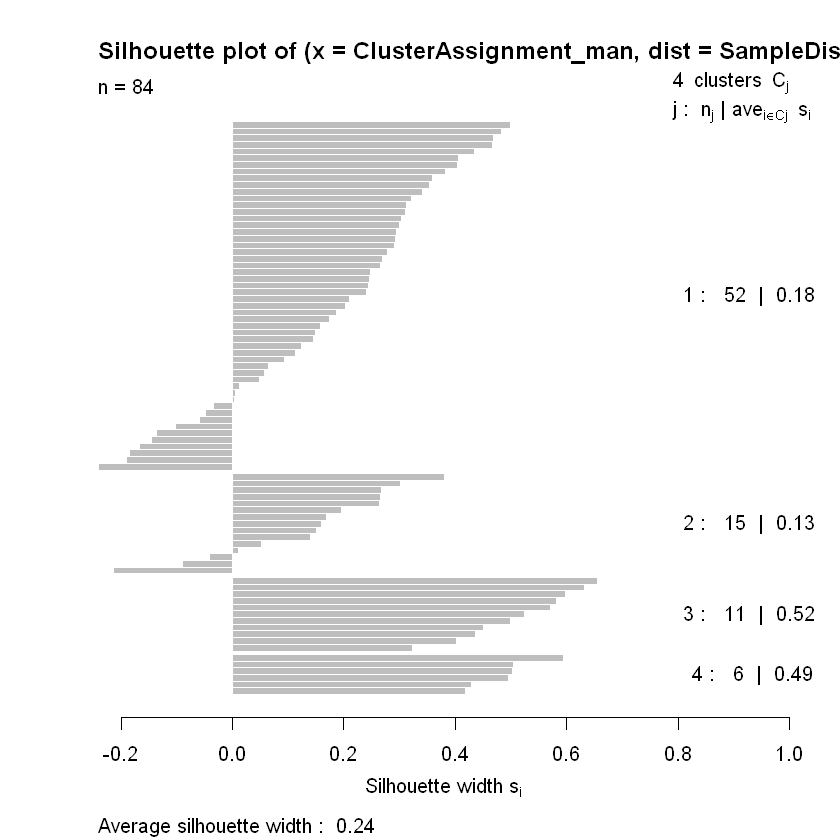

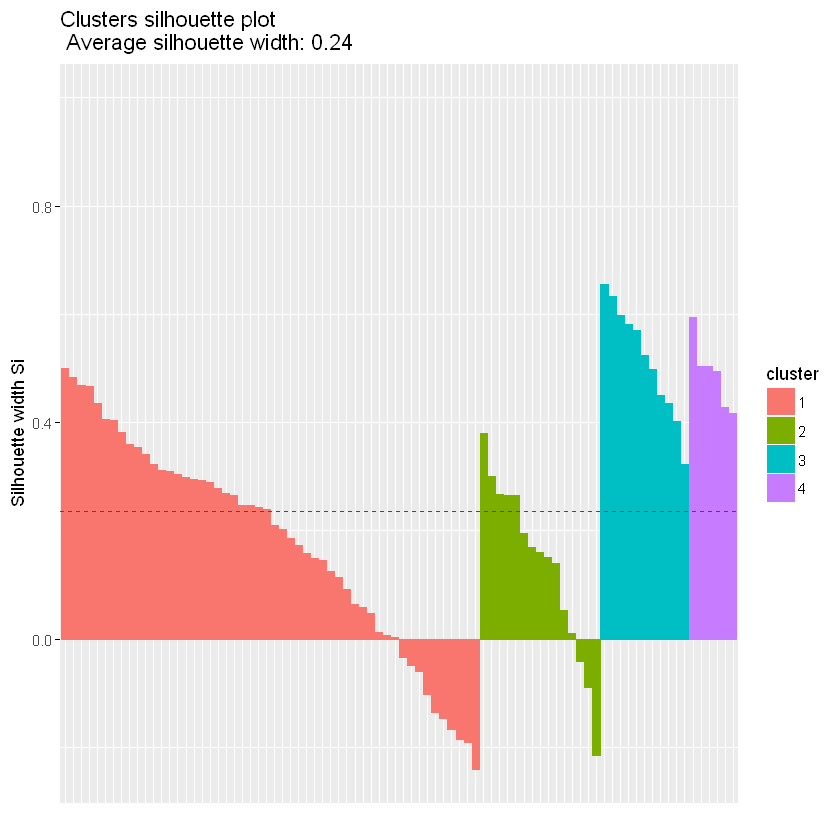

In [187]:
# Evaluating silhouette widths for this clustering method - shows worse average silhouette width of 0.24
SampleDistance3 <- dist(TopMRScale_transposed, method = "manhattan")
sil3 <- silhouette(ClusterAssignment_man, SampleDistance3)
plot(sil3) 
fviz_silhouette(sil3) 

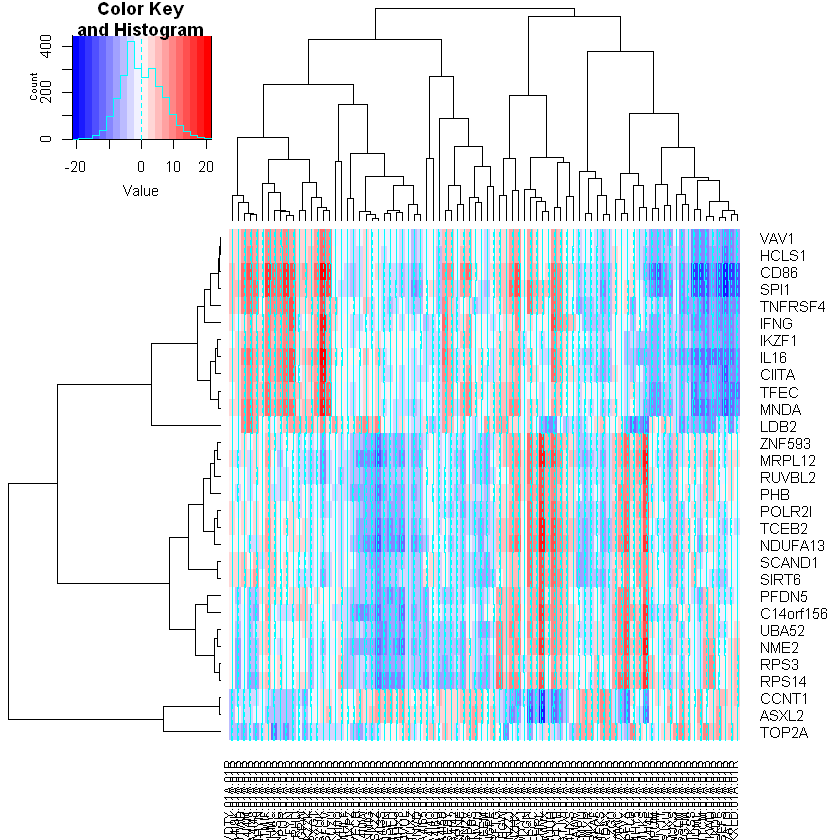

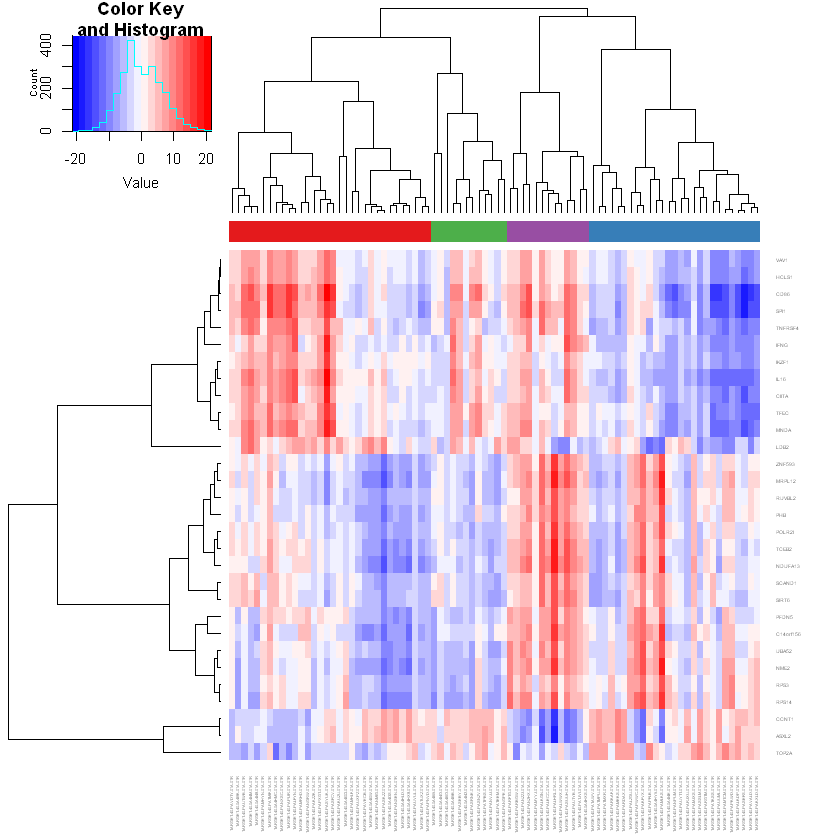

In [188]:
TopMRScale %<>% as.matrix
hm_spearman <- heatmap.2(TopMRScale, col = colorRampPalette(c('blue','white','red'))(n=20), 
                         Rowv=as.dendrogram(hr),
                         Colv=as.dendrogram(hc))

SampleClusters_spearman <- as.hclust(hm_spearman$colDendrogram)
ClusterAssignment_spearman <- cutree(SampleClusters_spearman, k = 4)
sidecols_spearman <- brewer.pal(4, "Set1")[ClusterAssignment_spearman]

# Using spearman correlation and complete linkage, again cutting the tree to form 4 clusters
hc <- hclust(as.dist(1-cor(TopMRScale, method='spearman')), method ='complete')
hr <- hclust(as.dist(1-cor(t(TopMRScale), method='spearman')), method ='complete')
hm_spearman <- heatmap.2(TopMRScale, col = colorRampPalette(c('blue','white','red'))(n=20), 
                         Rowv=as.dendrogram(hr),
                         Colv=as.dendrogram(hc),
                         ColSideColors = sidecols_spearman, trace = "none",
                         cexRow = 0.4, cexCol = 0.3)

  cluster size ave.sil.width
1       1   32          0.16
2       2   27          0.30
3       3   12          0.09
4       4   13          0.47


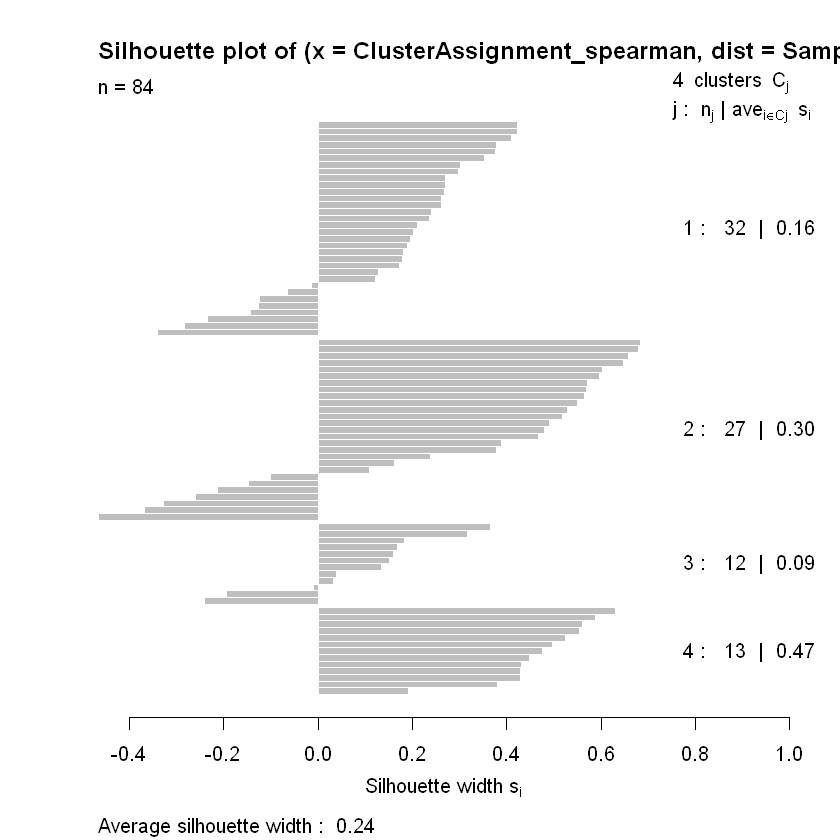

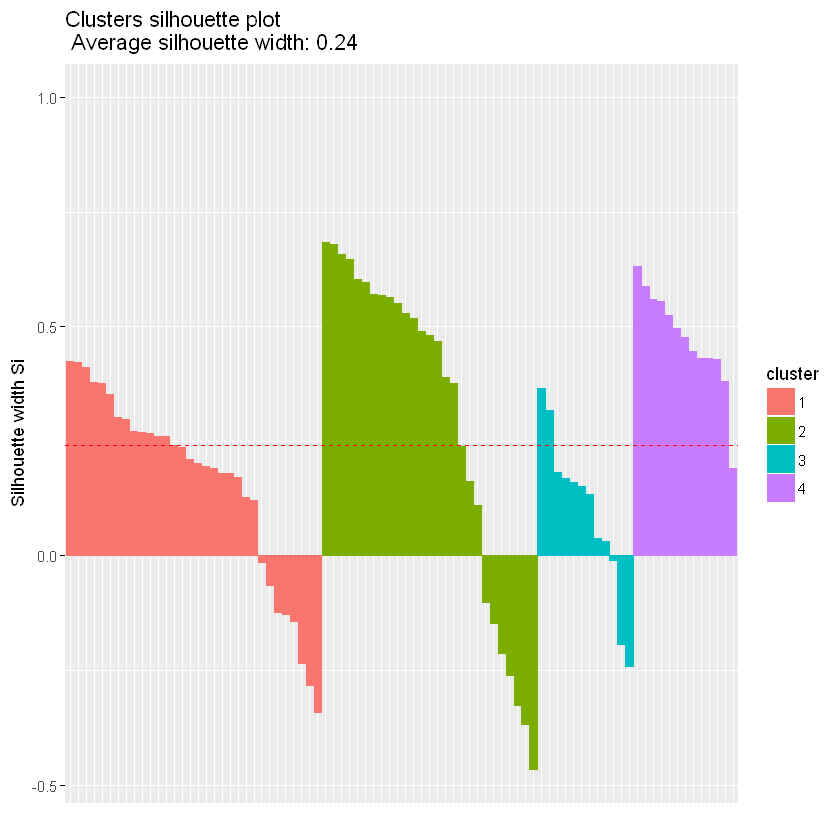

In [91]:
# Evaluating silhouette widths for this clustering method - shows worse average silhouette width of 0.24
SampleDistance2 <- as.dist(1-cor(TopMRScale, method = 'spearman'))
sil2 <- silhouette(ClusterAssignment_spearman, SampleDistance2)
plot(sil2) 
fviz_silhouette(sil2) 


# Question 2: Evaluating differences among the MR clusters with regard to phenotypic characteristics 


In [192]:
clus1_spearman <- ClusterAssignment_spearman

 Used cluster assignment obtained from hierarchical clustering using Euclidean distance (ClusterAssignment)


In [193]:
RelapseEvent <- as.matrix(events[1:84])
RelapseEvent <- replace(RelapseEvent, RelapseEvent == "Relapse", 1)
RelapseEvent <- replace(RelapseEvent, RelapseEvent == "Death", 1)
RelapseEvent <- replace(RelapseEvent, RelapseEvent == "No event", 0)
names(ClusterAssignment) <- names(ClusterAssignment) %>% gsub(".01A.01R", "", .) %>% gsub("\\.", "-", .)
ClusterAssignment2 <- as.matrix(ClusterAssignment)
ClusterAssignment_spearman <- as.matrix(clus1_spearman)
rows <- intersect(rownames(ClusterAssignment2), rownames(RelapseEvent))
RelapsebyCluster <- cbind(ClusterAssignment2[rows,], RelapseEvent[rows,])
RelapsebyCluster <- as.data.frame(RelapsebyCluster)
RelapseCT <- as.matrix(table(RelapsebyCluster))

In [194]:
# Ran Chi-squared test
chisq.test(RelapseCT) # X-squared = 5.2308, df = 3, p-value = 0.1557
# As some category values were <5, ran Fisher's exact test instead
fisher.test(RelapseCT) # p-value = 0.156

Warning message in chisq.test(RelapseCT):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  RelapseCT
X-squared = 5.2308, df = 3, p-value = 0.1557



	Fisher's Exact Test for Count Data

data:  RelapseCT
p-value = 0.156
alternative hypothesis: two.sided


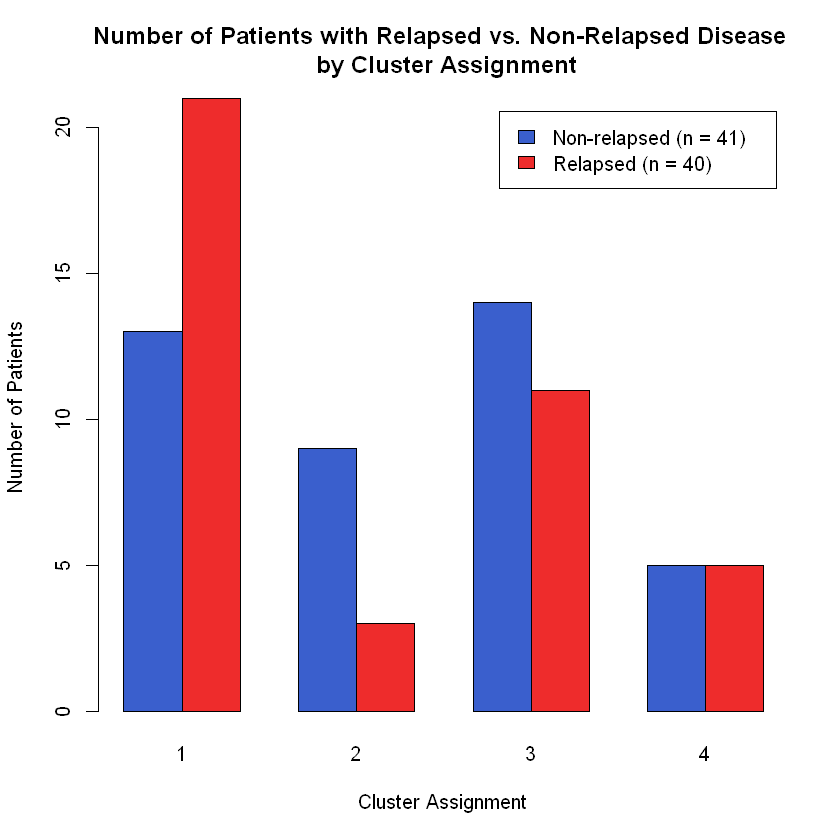

In [195]:
# To illustrate findings of Chi-squared test for relapse using barplots
barplot(t(RelapseCT), beside = TRUE, 
        legend.text = c("Non-relapsed (n = 41)", "Relapsed (n = 40)"), 
        col = c("royalblue3", "firebrick2"), 
        main = "Number of Patients with Relapsed vs. Non-Relapsed Disease \n by Cluster Assignment",
        xlab = "Cluster Assignment",
        ylab = "Number of Patients")

In [196]:
# Used Chi-squared test to evaluate association between cluster assignment and Metastatic vs. Non-Metastatic
# Organizing data to be able to run Chi-squared test
Metastatic <- as.matrix(DxDisease)
Metastatic <- replace(Metastatic, Metastatic == "Metastatic", 1)
Metastatic <- replace(Metastatic, Metastatic == "Non-metastatic", 0)
rows2 <- intersect(rownames(ClusterAssignment2), rownames(Metastatic))
MetastaticbyCluster <- cbind(ClusterAssignment2[rows2,], Metastatic[rows2,])
MetastaticbyCluster <- as.data.frame(MetastaticbyCluster)
MetastaticCT <- as.matrix(table(MetastaticbyCluster))
# Ran Chi-squared test
chisq.test(MetastaticCT) # X-squared = 2.3708, df = 3, p-value = 0.4991
# As some category values were <5, ran Fisher's exact test instead
fisher.test(MetastaticCT) # p-value = 0.5194

Warning message in chisq.test(MetastaticCT):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  MetastaticCT
X-squared = 2.3708, df = 3, p-value = 0.4991



	Fisher's Exact Test for Count Data

data:  MetastaticCT
p-value = 0.5194
alternative hypothesis: two.sided


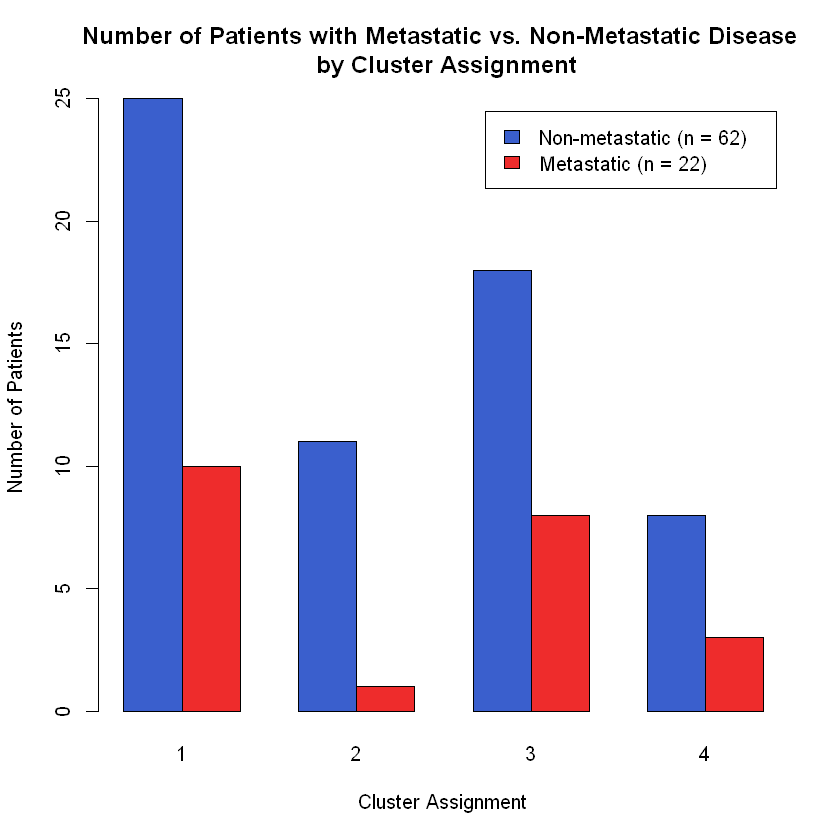

In [197]:
# To illustrate findings of Chi-squared test for metastasis using barplots
barplot(t(MetastaticCT), beside = TRUE, 
        legend.text = c("Non-metastatic (n = 62)", "Metastatic (n = 22)"), 
        col = c("royalblue3", "firebrick2"), 
        main = "Number of Patients with Metastatic vs. Non-Metastatic Disease \n by Cluster Assignment",
        xlab = "Cluster Assignment",
        ylab = "Number of Patients")

In [231]:
# Used Cox regression / log-rank test and kaplan meier curves to evaluate differences between cluster assignment and EFS and OS
# Overall survival:
rownames(OSClinical) <- OSClinical$`TARGET.USI`
joint <- intersect(rownames(ClusterAssignment2), rownames(OSClinical))
ClinicalCluster <- cbind(ClusterAssignment2[joint,], OSClinical[joint,])
survival_data <- ClinicalCluster %>% select(`Overall.Survival.Time.in.Days`, `Vital.Status`, `ClusterAssignment2[joint, ]`)
survival_data <- survival_data %>% mutate(status = as.factor(`Vital.Status`)) %>% mutate(cluster = as.factor(`ClusterAssignment2[joint, ]`) %>% as.factor)
survival_data <- survival_data[complete.cases(survival_data),]
survival_data <- survival_data %>% mutate(cluster_bin = c(1,2,3,4)[cluster]) %>% mutate(days = `Overall.Survival.Time.in.Days`)
survival_data$status_bin <- c(0,1)[survival_data$status] %>% as.numeric

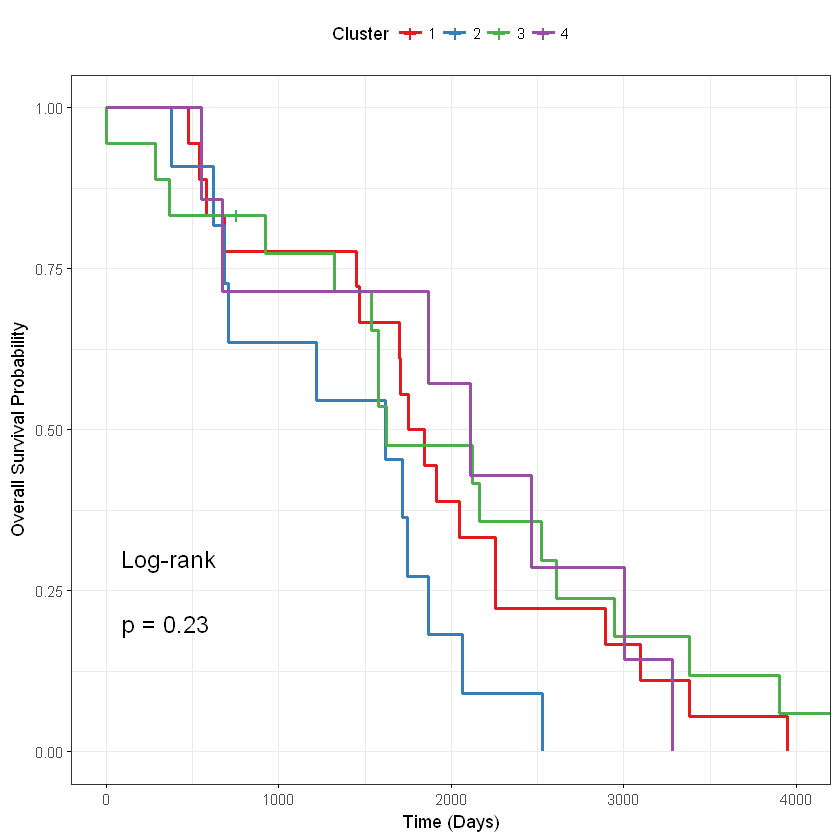

In [232]:
# Comparison using log-rank test which is slightly different from Cox proportional hazards
fit <- survfit(Surv(days, status_bin) ~ cluster, data =  survival_data)
# Plotting Kaplan Meirer survival curves with results of the log-rank test
ggsurvplot(fit, 
           legend.title = "Cluster",
           legend.labs = c("1", "2", "3", "4"),
           pval = TRUE,
           pval.method = TRUE,
           conf.int = FALSE,
           # Add risk table
           #risk.table = TRUE,
           #tables.height = 0.2,
           #tables.theme = theme_cleantable(),
           ylab = "Overall Survival Probability",
           xlab = "Time (Days)",
           cex.lab = 10,
           palette = brewer.pal(4, "Set1"),
           ggtheme = theme_bw() 
)

In [233]:
# Also did pairwise comparison between clusters using log-rank test
OS_pairwise_pvalues <- pairwise_survdiff(Surv(days, status_bin) ~ cluster, data = survival_data, p.adjust.method = "none", rho = 0)
# No statistical difference when looking between all groups. Pairwise comparison shows statistical difference between MR groups 1 and 2 with p value 0.042 only when you don't adjust for multiple hypothesis testing, otherwise no difference.

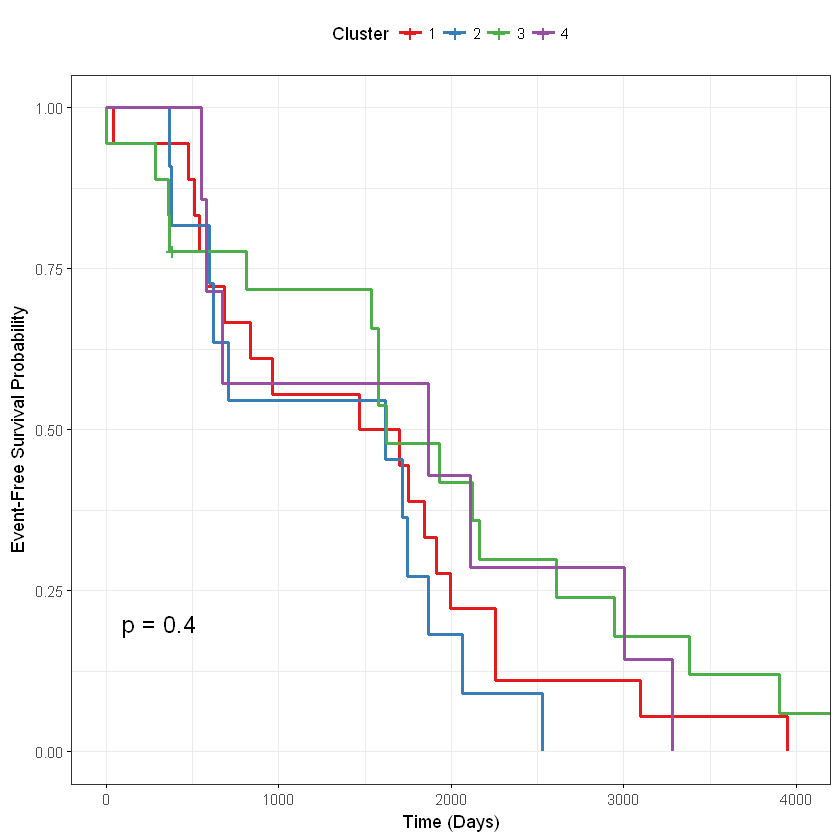

In [235]:
# Event-free survival (survival until a first event (relapse, death, secondary malignancy))
survival_data2 <- ClinicalCluster %>% select(`Time.to.First.Event.in.Days`, `Vital.Status`, `ClusterAssignment2[joint, ]`)
survival_data2 <- survival_data2 %>% mutate(status = as.factor(`Vital.Status`)) %>% mutate(cluster = as.factor(`ClusterAssignment2[joint, ]`) %>% as.factor)
survival_data2 <- survival_data2[complete.cases(survival_data2),]
survival_data2 <- survival_data2 %>% mutate(cluster_bin = c(1,2,3,4)[cluster]) %>% mutate(days2 = `Time.to.First.Event.in.Days`)
survival_data2$status_bin <- c(0,1)[survival_data2$status] %>% as.numeric
# Comparison using log-rank test which is slightly different from Cox proportional hazards
fit_EFS <- survfit(Surv(days2, status_bin) ~ cluster, data =  survival_data2)
# Plotting Kaplan Meirer survival curves with results of the log-rank test
ggsurvplot(fit_EFS, 
           legend.title = "Cluster",
           legend.labs = c("1", "2", "3", "4"),
           # Add p-value and tervals
           pval = TRUE,
           pval.method = FALSE,
           conf.int = FALSE,
           # Add risk table
           #risk.table = TRUE,
           #tables.height = 0.2,
           #tables.theme = theme_cleantable(),
           ylab = "Event-Free Survival Probability",
           xlab = "Time (Days)",
           #cex.lab = 10,
           palette = brewer.pal(4, "Set1"),
           ggtheme = theme_bw() 
)

In [236]:
# Also did pairwise comparison between clusters using log-rank test
OS_pairwise_pvalues_EFS <- pairwise_survdiff(Surv(days2, status_bin) ~ cluster, data = survival_data2, p.adjust.method = "none", rho = 0)
# No statistical difference when looking between all groups. Pairwise comparison shows statistical difference between MR groups 1 and 2 with p value 0.042 only when you don't adjust for multiple hypothesis testing, otherwise no difference.

[1] "data.frame"

X,TARGET-40-0A4HLD,TARGET-40-PAPIJR,TARGET-40-PAMHLF,TARGET-40-PATAWV,TARGET-40-0A4I42,TARGET-40-PAMJXS,TARGET-40-PALECC,TARGET-40-0A4HMC,TARGET-40-0A4I6O,...,TARGET-40-PASRNE,TARGET-40-PAMHYN,TARGET-40-0A4I4O,TARGET-40-PAPKWD,TARGET-40-PASEBY,TARGET-40-0A4I0Q,TARGET-40-PAVDTY,TARGET-40-PARBGW,TARGET-40-PAUUML,TARGET-40-PAMLKS
NR2E3,2.20557769,2.1154299,-0.14191308,-1.33085620,1.07954611,-2.0411488,-0.60593543,1.59155508,-1.1423878,...,-0.1846615,0.521655767,1.7583618,-0.755329219,-0.22277369,0.6414168,0.92695544,0.62151888,-0.15831820,1.2373218
ZBTB33,-1.19398354,-3.3481249,-0.09022615,3.59856598,1.02928524,0.7304290,-2.24572348,-3.79432828,3.2708539,...,3.4476034,-0.225985660,-1.4862290,2.919568656,0.99651448,0.5207602,-2.73078626,-1.88699270,2.23860691,-3.2826666
ZSCAN30,2.33796269,0.4390957,1.36825466,1.95103719,1.99996013,-2.0628696,-3.12646216,-0.73221041,1.1146459,...,2.2082129,-0.612106470,1.2860902,-0.663459154,-0.15451435,1.8221331,-0.95341782,-2.20428198,2.10101564,-4.3516388
ZGLP1,2.30094399,4.8839204,0.85812717,-2.60120589,2.10167392,-3.0163279,1.01499017,2.54981728,-2.5248816,...,-1.5444654,-0.886179627,5.3038570,-2.456386381,-1.83722909,2.2064826,2.07221559,-0.90918098,1.25473660,3.4081440
ZNF737,1.93008823,-0.8183007,1.78174502,0.44694392,0.46804626,-2.1129254,-3.07689365,-0.27030182,1.5389946,...,2.4251626,0.555736793,-0.5865586,-0.932599590,0.53366144,0.1457182,-1.06276890,-0.09724471,1.60881569,-1.8677294
HSFX2,1.37605118,2.8980352,0.84767983,-2.46525457,0.50281340,-1.4103335,-1.47743269,2.27367620,-1.6757135,...,-2.3693702,0.601252365,2.1018939,-1.965517568,-1.40758670,0.5040441,2.01953748,-1.24891891,0.06469843,-0.7293746
ZNF717,1.60933765,-0.7002633,0.94536862,0.81212373,0.57106670,-1.5543054,-2.54061679,-0.81718530,0.6215179,...,1.7105584,0.121002833,-0.3699340,0.985145180,0.68404649,0.7003069,-1.14622338,-0.61180904,1.82397171,-2.4827995
MEF2B,1.42037943,3.1035779,0.34527983,-2.79314826,0.61336861,-1.7586091,0.52507773,2.94704140,-1.9634218,...,-2.0578971,-0.268929702,2.5678608,-2.324556349,-1.12852054,0.4172982,2.25330610,-0.07349868,-0.35463862,2.7649440
HSFX1,1.25460806,2.2902055,-0.58048086,-2.23280178,0.51655045,-1.0345669,-0.09677184,1.48272277,-2.2957096,...,-2.6631796,0.344306187,0.1742472,0.675413865,-0.47785812,1.4933482,1.64671006,0.04255660,-0.19441318,1.6225852
NR1H3,-1.97452058,5.8850497,-1.22523124,-2.86322446,-1.92754966,0.5475436,3.54193146,4.83014134,-2.8388945,...,-0.2682270,1.915663477,1.1745294,-3.352118294,2.83693845,-0.3835192,2.51166521,2.62754510,-5.83450229,1.7459065


In [ ]:
# We also performed associations between cluster assignment and these outcomes (relapse, metastasis, OS, and EFS) using the clusters generated from Manhattan distance and Spearman correlation, however saw worse clinical correlation in these cases.
# This further lead us to use hierarchical clustering with Euclidean distance as our final clustering method.

## Comaprison of MR activity and Relapse vs. Non-relapse (or Metastatic vs. Non-metastatic) using T-test across each MR to identify MRs that are most differentially active between patients who relapsed (have metastatic disease) and those who didn't.
colnames(TOS_viper_LogTPM_Scale) <- colnames(TOS_viper_LogTPM_Scale) %>% gsub(".01A.01R", "", .) %>% gsub("\\.", "-", .)
colnames(TopMRScale) <- colnames(TopMRScale) %>% gsub(".01A.01R", "", .) %>% gsub("\\.", "-", .)

#TOS_viper_clean <- T
TOS_viper_clean <- TOS_viper_LogTPM_Scale[!duplicated(TOS_viper_LogTPM_Scale$X),]
TOS_viper_clean <- TOS_viper_clean[!is.na(TOS_viper_clean$X),]
rownames(TOS_viper_clean) <- TOS_viper_clean$X
TOS_viper_clean %<>% .[,-1]

In [265]:
# rowTtest in the viper package calculates T test across each row based on a phenotype.
# TtestByPhenotyp is a function that calculates row T tests using rowTtest across genes between two phenotypes for our dataset and returns the genes whose p-value is < 0.01.
# We didn't do multiple hypothesis testing correction because, giving the small number of samples to features, everything becomes insignificant, and we just need to find the potential best MRs for feature selection for the classifier and to review biologically, and are not planning to take this as absolute truth.
TtestByPhenotype <- function(viper_dset, phenotype){
  columns <- intersect(colnames(viper_dset), rownames(phenotype))
  vipex_phenotype <- viper_dset[,columns]
  outcome <- as.data.frame(phenotype)
  outcome <- outcome[which(rownames(outcome) %in% columns),]
  outcome <- as.data.frame(outcome)
  outcomeIDs <- subset(outcome, outcome == 1)
  outcomeIDs <- rownames(outcomeIDs)
  nonoutcomeIDs <- subset(outcome, outcome == 0)
  nonoutcomeIDs <- rownames(nonoutcomeIDs)
  outcomeNES <- vipex_phenotype[,outcomeIDs]
  nonoutcomeNES <- vipex_phenotype[,nonoutcomeIDs]
  OutcomeTtest <- rowTtest(x = outcomeNES, y = nonoutcomeNES, alternative = "greater")
  pvalues <- OutcomeTtest$p.value
  OutcomeMRs <- OutcomeTtest$p.value[which(OutcomeTtest$p.value < 0.01),]
  return(OutcomeMRs)
}

,TARGET-40-0A4HLD,TARGET-40-PAPIJR,TARGET-40-PAMHLF,TARGET-40-PATAWV,TARGET-40-0A4I42,TARGET-40-PAMJXS,TARGET-40-PALECC,TARGET-40-0A4HMC,TARGET-40-0A4I6O,TARGET-40-PANMIG,...,TARGET-40-PASRNE,TARGET-40-PAMHYN,TARGET-40-0A4I4O,TARGET-40-PAPKWD,TARGET-40-PASEBY,TARGET-40-0A4I0Q,TARGET-40-PAVDTY,TARGET-40-PARBGW,TARGET-40-PAUUML,TARGET-40-PAMLKS
NR2E3,2.20557769,2.1154299,-0.14191308,-1.33085620,1.07954611,-2.0411488,-0.60593543,1.59155508,-1.1423878,0.06557698,...,-0.1846615,0.521655767,1.7583618,-0.755329219,-0.22277369,0.6414168,0.92695544,0.62151888,-0.15831820,1.2373218
ZBTB33,-1.19398354,-3.3481249,-0.09022615,3.59856598,1.02928524,0.7304290,-2.24572348,-3.79432828,3.2708539,1.11908839,...,3.4476034,-0.225985660,-1.4862290,2.919568656,0.99651448,0.5207602,-2.73078626,-1.88699270,2.23860691,-3.2826666
ZSCAN30,2.33796269,0.4390957,1.36825466,1.95103719,1.99996013,-2.0628696,-3.12646216,-0.73221041,1.1146459,2.66889152,...,2.2082129,-0.612106470,1.2860902,-0.663459154,-0.15451435,1.8221331,-0.95341782,-2.20428198,2.10101564,-4.3516388
ZGLP1,2.30094399,4.8839204,0.85812717,-2.60120589,2.10167392,-3.0163279,1.01499017,2.54981728,-2.5248816,-0.07438895,...,-1.5444654,-0.886179627,5.3038570,-2.456386381,-1.83722909,2.2064826,2.07221559,-0.90918098,1.25473660,3.4081440
ZNF737,1.93008823,-0.8183007,1.78174502,0.44694392,0.46804626,-2.1129254,-3.07689365,-0.27030182,1.5389946,1.35915284,...,2.4251626,0.555736793,-0.5865586,-0.932599590,0.53366144,0.1457182,-1.06276890,-0.09724471,1.60881569,-1.8677294
HSFX2,1.37605118,2.8980352,0.84767983,-2.46525457,0.50281340,-1.4103335,-1.47743269,2.27367620,-1.6757135,2.18514050,...,-2.3693702,0.601252365,2.1018939,-1.965517568,-1.40758670,0.5040441,2.01953748,-1.24891891,0.06469843,-0.7293746
ZNF717,1.60933765,-0.7002633,0.94536862,0.81212373,0.57106670,-1.5543054,-2.54061679,-0.81718530,0.6215179,1.91939949,...,1.7105584,0.121002833,-0.3699340,0.985145180,0.68404649,0.7003069,-1.14622338,-0.61180904,1.82397171,-2.4827995
MEF2B,1.42037943,3.1035779,0.34527983,-2.79314826,0.61336861,-1.7586091,0.52507773,2.94704140,-1.9634218,-0.53538382,...,-2.0578971,-0.268929702,2.5678608,-2.324556349,-1.12852054,0.4172982,2.25330610,-0.07349868,-0.35463862,2.7649440
HSFX1,1.25460806,2.2902055,-0.58048086,-2.23280178,0.51655045,-1.0345669,-0.09677184,1.48272277,-2.2957096,1.68802276,...,-2.6631796,0.344306187,0.1742472,0.675413865,-0.47785812,1.4933482,1.64671006,0.04255660,-0.19441318,1.6225852
NR1H3,-1.97452058,5.8850497,-1.22523124,-2.86322446,-1.92754966,0.5475436,3.54193146,4.83014134,-2.8388945,-2.00085229,...,-0.2682270,1.915663477,1.1745294,-3.352118294,2.83693845,-0.3835192,2.51166521,2.62754510,-5.83450229,1.7459065


In [267]:
# MRs for relapse
TtestByPhenotype(TOS_viper_clean %>% as.matrix, RelapseEvent)
# MRs for metastatic disease
TtestByPhenotype(TOS_viper_clean %>% as.matrix, Metastatic)

ZDHHC6       THOC1       TIAL1       TDRD3      HNRPDL      OR5D18 
0.009237867 0.008013194 0.006834675 0.008633804 0.008008410 0.002717022 
      OR4S1      CLEC2D       OR4A5       PTPLA 
0.004451857 0.006664323 0.003502850 0.006995229

ING1        DEDD      OR10Q1       OR1L4      OR10R2       OR8K1 
0.004080920 0.005421745 0.009775809 0.006590114 0.008393349 0.002865266 
   ZNF32OS1 
0.009490950

# Question 3: Can we predict relapse after chemotherapy based on abberantly active MRs?

For supervised subject clustering, we decided to use the significant MRs identified from multpile T tests in the previous section. All superised analyses are performed with the `caret` package in R

Clean up the dataset for use in the caret package

In [282]:
ttest_signifncant_MRs <- c("SSX2", "OR5D18", "OR4S1", "OR4A5", "IL2RA", "SLAMF7", "SIRPG")
#ttest_signifncant_MRs <- c("ZDHHC6", "THOC1", "TIAL1", "TDRD3", "HNRPDL", "OR5D18", "OR4S1", "CLEC2D", "OR4A5", "PTPLA")

viper_dset_caret <- TOS_viper_LogTPM_Scale %>% filter(X %in% ttest_signifncant_MRs)
names(viper_dset_caret) %<>% str_remove("\\.01A\\.01R")

names(DxDisease) %<>% str_replace_all("\\.", "-")

viper_dset_caret %<>% as.data.frame
rownames(viper_dset_caret) <- viper_dset_caret$X
viper_dset_caret %<>% .[,-1] %>% t

events[which(events == "Death")] <- "Relapse"
events %<>% factor(levels = c("No event", "Relapse"))

# Add relapse and metastasis column
viper_dset_caret <- data.frame(viper_dset_caret, 
                               relapse = events[rownames(viper_dset_caret)], 
                            metastatic = DxDisease[rownames(viper_dset_caret)])

# Remove samples with no data
viper_dset_caret <- viper_dset_caret[!is.na(viper_dset_caret$relapse),]

In [284]:
library(caret)

In [285]:
trainTest <- createDataPartition(viper_dset_caret$relapse, p = .75, list = FALSE)
caret_train <- viper_dset_caret[trainTest,]
caret_test <- viper_dset_caret[-trainTest,]
library(prettyR)
describe(caret_train)

Description of caret_train 



 Numeric 
        mean median  var   sd valid.n
SSX2    0.01  -0.26 1.85 1.36      61
OR5D18  0.03   0.03 0.06 0.25      61
OR4S1   0.01   0.01 0.05 0.22      61
OR4A5  -0.03  -0.06 0.05 0.23      61
IL2RA   0.09   0.16 2.73 1.65      61
SLAMF7  0.14   0.30 3.06 1.75      61
SIRPG   0.01  -0.05 1.42 1.19      61

 Factor 
         
relapse   No event Relapse
  Count      31.00   30.00
  Percent    50.82   49.18
Mode No event 
          
metastatic Non-metastatic Metastatic
   Count            45.00      16.00
   Percent          73.77      26.23
Mode Non-metastatic 

Make a training control variable

In [286]:
ctrl <- trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 10)

## 3.1 Support Vector Machine
We try different value of C to get the best accuracy 

In [289]:
grid <- expand.grid(C = c(0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2,5))
svm_linear_grid <- train(relapse~., data = caret_train, 
                   method = "svmLinear", 
                   trControl = ctrl, 
                   preProcess = c("center", "scale"), 
                   tuneGrid = grid,
                   tuneLength = 10)
svm_linear_grid

Support Vector Machines with Linear Kernel 

61 samples
 8 predictor
 2 classes: 'No event', 'Relapse' 

Pre-processing: centered (8), scaled (8) 
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 55, 54, 55, 55, 55, 55, ... 
Resampling results across tuning parameters:

  C     Accuracy   Kappa    
  0.01  0.6885714  0.3768599
  0.05  0.6885714  0.3763651
  0.10  0.6576190  0.3166868
  0.25  0.6485714  0.2984560
  0.50  0.6464286  0.2934159
  0.75  0.6402381  0.2811492
  1.00  0.6435714  0.2881888
  1.25  0.6419048  0.2848555
  1.50  0.6450000  0.2909786
  1.75  0.6464286  0.2942988
  2.00  0.6347619  0.2709655
  5.00  0.6219048  0.2448785

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was C = 0.01.

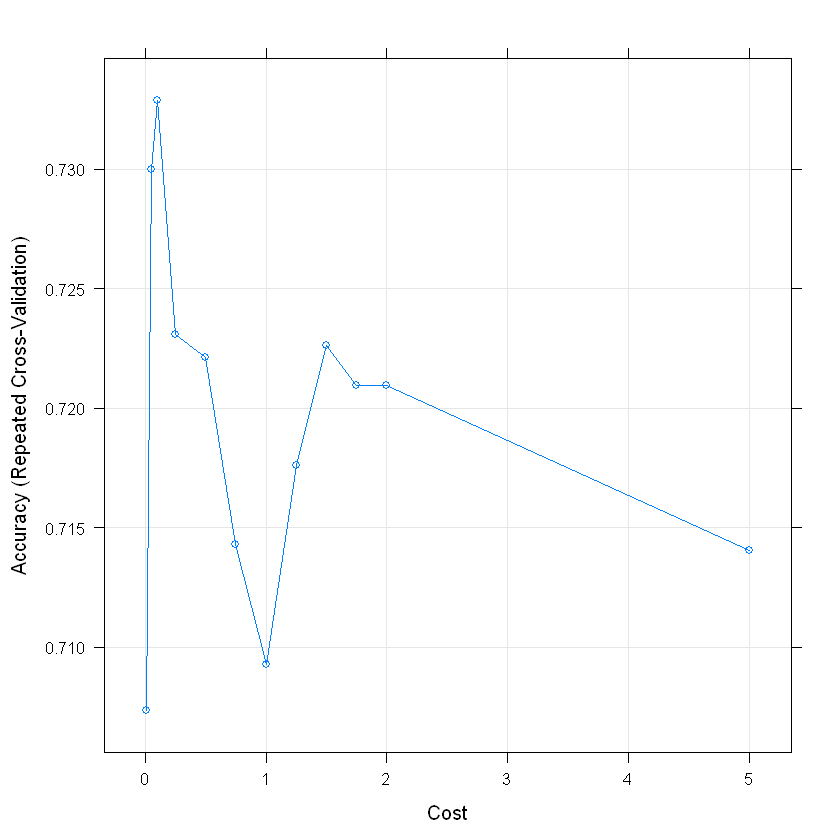

In [162]:
plot(svm_linear_grid)

## 3.2 Random Forest Model

In [291]:
rfFit <- train(relapse ~ ., data = caret_train, 
                 method = "rf", 
                 trControl = ctrl, 
                 tuneLength = 4)
rfFit    

Random Forest 

61 samples
 8 predictor
 2 classes: 'No event', 'Relapse' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 55, 55, 55, 54, 55, 55, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  2     0.6707143  0.3410187
  4     0.6523810  0.3041187
  6     0.6540476  0.3074419
  8     0.6490476  0.2974419

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.

## 3.3 Naive Bayes Classifier

In [292]:
nbFit <- train(relapse ~ ., data = caret_train, 
                 method = "naive_bayes", 
                 trControl = ctrl, 
                 tuneLength = 4)
nbFit    

Naive Bayes 

61 samples
 8 predictor
 2 classes: 'No event', 'Relapse' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 55, 55, 55, 55, 55, 55, ... 
Resampling results across tuning parameters:

  usekernel  Accuracy   Kappa    
  FALSE      0.7095238  0.4184415
   TRUE      0.7064286  0.4113623

Tuning parameter 'laplace' was held constant at a value of 0
Tuning
 parameter 'adjust' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were laplace = 0, usekernel = FALSE
 and adjust = 1.

## Evaluation of Unsupervised Methods
Resample to get overall evaluations

In [293]:
resamps <- resamples(list(NBC = nbFit,
                          SVM = svm_linear_grid,
                          RNF = rfFit))
summary(resamps)


Call:
summary.resamples(object = resamps)

Models: NBC, SVM, RNF 
Number of resamples: 100 

Accuracy 
         Min.   1st Qu.    Median      Mean   3rd Qu. Max. NA's
NBC 0.3333333 0.6666667 0.6666667 0.7095238 0.8333333    1    0
SVM 0.3333333 0.5000000 0.6666667 0.6885714 0.8333333    1    0
RNF 0.3333333 0.5000000 0.6666667 0.6707143 0.8333333    1    0

Kappa 
          Min.   1st Qu.    Median      Mean   3rd Qu. Max. NA's
NBC -0.3333333 0.3333333 0.3333333 0.4184415 0.6666667    1    0
SVM -0.3333333 0.0000000 0.3333333 0.3768599 0.6666667    1    0
RNF -0.3333333 0.0000000 0.3333333 0.3410187 0.6666667    1    0


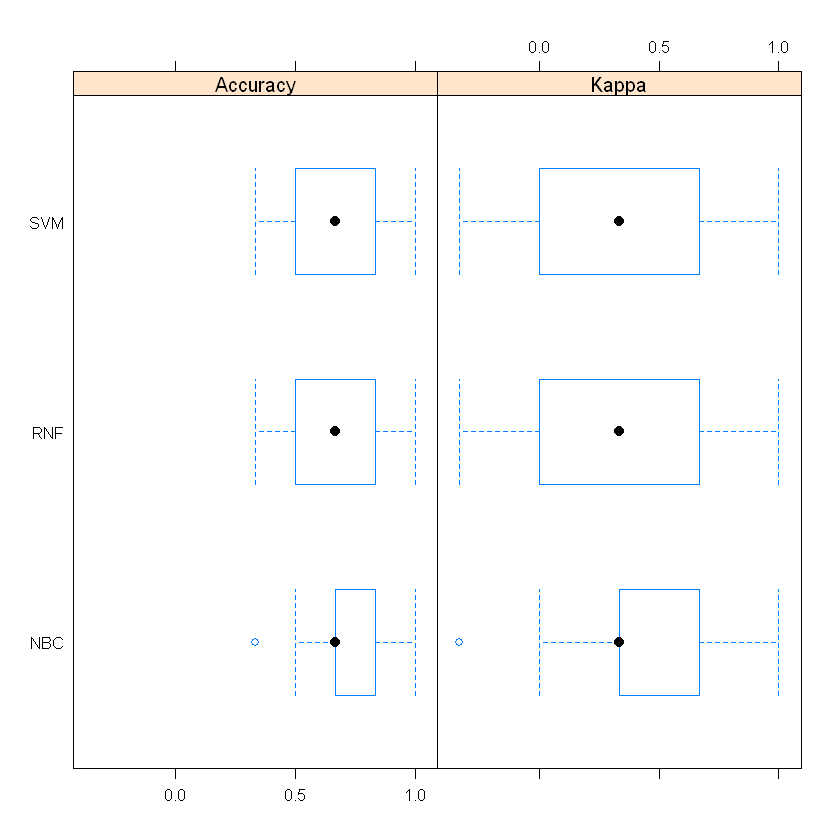

In [294]:
bwplot(resamps)

#### Test the three different classifiers on the held out test set

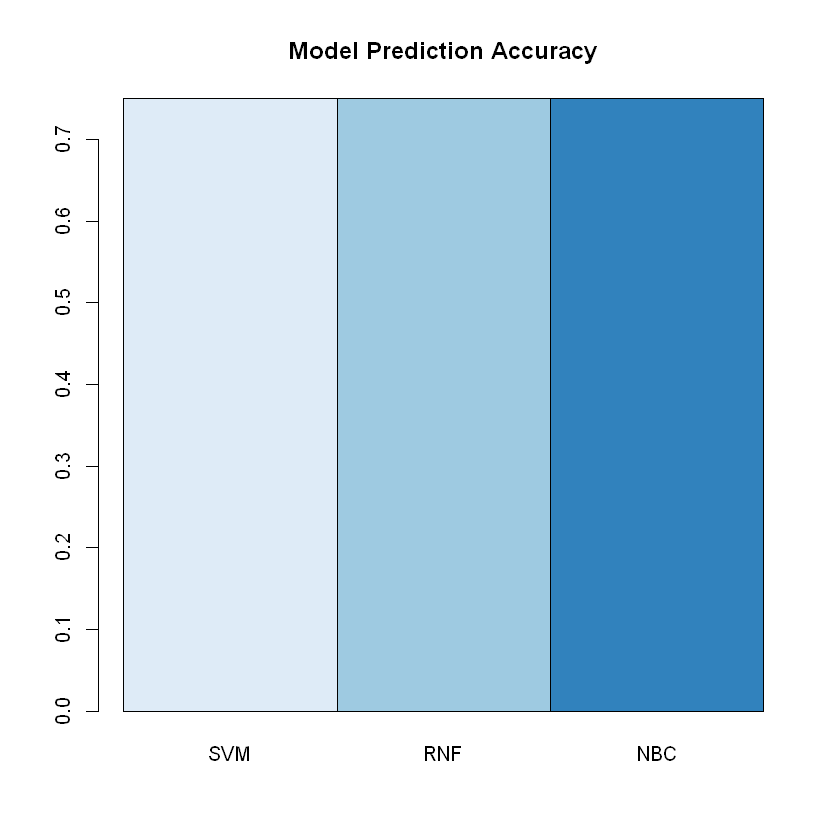

In [295]:
preds.svm <- predict.train(svm_linear_grid, newdata = caret_test, type = "raw")
preds.rnf <- predict.train(rfFit, newdata = caret_test, type = "raw")
preds.nbc <- predict.train(nbFit, newdata = caret_test, type = "raw")
results.svm <- confusionMatrix(preds.svm, caret_test$relapse %>% as.factor, positive = "Relapse")
results.rnf <- confusionMatrix(preds.rnf, caret_test$relapse %>% as.factor, positive = "Relapse")
results.nbc <- confusionMatrix(preds.nbc, caret_test$relapse %>% as.factor, positive = "Relapse")
list(results.svm, results.rnf, results.nbc) %>% 
  map("overall") %>% map_dbl("Accuracy") %>% 
  barplot(names = c("SVM", "RNF", "NBC"), col = brewer.pal(3, "Blues"), main = "Model Prediction Accuracy", axes = TRUE, beside = TRUE, space = 0)